# Natural Language Processing Project
## NLP Course @ Politecnico di Milano 2024/2025 - Prof. Mark Carman
### Topic 8: Medical Question Answering
Dataset: 
* PubMedQA [link](https://huggingface.co/datasets/qiaojin/PubMedQA )

Reference paper:
* PubMedQA: A Dataset for Biomedical Research Question Answering [Link](https://arxiv.org/pdf/1909.06146)

## Group members:

* Ketrin Mehmeti
* Giulia Ghiazza
* Leonardo Giorgio Franco
* Edoardo Franco Mattei
* Alessandro Epifania

## Introduction
 
The PubMedQA dataset is an innovative resource for question answering (QA) in the biomedical field, created from abstracts of scientific articles available on PubMed. The main purpose of PubMedQA is to assess the reasoning and inference abilities of intelligent systems on natural language, particularly within the context of biomedical research texts, which often require the processing of quantitative content.

A typical instance in PubMedQA consists of the following components:

* A question, which can either be the original title of a research paper or derived from it. For example: "Do preoperative statins reduce atrial fibrillation after coronary artery bypass grafting?"

* A context, which is the abstract corresponding to the question, excluding its conclusion.

* A long answer, represented by the conclusion of the abstract, which is expected to answer the research question.

* A short answer in the form of "yes," "no," or "maybe," summarizing the conclusion. In the provided example, the long answer is: "(Conclusion) Our study indicated that preoperative statin therapy seems to reduce AF development after CABG," while the short answer is "yes."

The PubMedQA dataset is divided into three subsets:

* PQA-L (Labeled): Contains 1k manually annotated instances with yes/no/maybe answers. These annotations were made in two modes: "reasoning-free," where the annotator had access to the long answer, and "reasoning-required," where the annotator could only rely on the context.

* PQA-U (Unlabeled): Consists of 61.2k unlabeled instances, made up of PubMed articles with question-form titles and structured abstracts.

* PQA-A (Artificial): Includes 211.3k artificially generated instances, where article titles in statement form are converted into questions, and yes/no answers are automatically assigned based on the presence or absence of negations in the original title.

A key feature of PubMedQA is that the contexts are generated to directly answer the questions, with both components written by the same authors, ensuring a strong relationship between the question and context. This makes PubMedQA an ideal benchmark for testing the scientific reasoning capabilities of machine reading comprehension models. The dataset often requires reasoning over the quantitative content found in abstracts to answer the questions.

### Description of the Expert-Annotated PQA-L Dataset

PQA-L is a key subset of the PubMedQA dataset, consisting of 1,000 manually labeled QA instances created for validation and testing. Each instance includes a question (usually a paper title), context (the abstract without the conclusion), a long answer (the conclusion), and a short yes/no/maybe label.

Two M.D. candidates annotated the data using two setups:

* Reasoning-free: the annotator saw the question, context, and long answer to assign the label directly.

* Reasoning-required: the annotator only saw the question and context, requiring inference without the conclusion.

Final labels were based on agreement between annotators, with disagreements resolved through discussion or instance removal. This dual-setup design highlights the task's difficulty: human accuracy drops from 90.4% (reasoning-free) to 78.0% (reasoning-required). The labels reflect the certainty or ambiguity of the article’s conclusion.

## Preliminary Initialization

Libraries necessary to run the code:

<mark style="background-color: white; color: black;">
pip install datasets  <br>
pip install transformers <br>
pip install torch <br>
pip install wordcloud <br>
pip install mpl_toolkits <br>
!pip install gensim --upgrade
</mark>


## Libraries

In [1]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import pandas as pd
import nltk
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report


C:\Users\213053\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Loading the dataset: 

The object dataset is a DatasetDict, and in this case instead of different splits like "train", "validation", and "test" contains only the "train" section. 


In [2]:
# Load the labeled, unlabeled, and artificial subsets of PubMedQA
# The dataset is split into three subsets:

dataset_labeled = load_dataset("qiaojin/PubMedQA", 'pqa_labeled')               
dataset_unlabeled = load_dataset("qiaojin/PubMedQA", 'pqa_unlabeled')    
dataset_artificial = load_dataset('qiaojin/PubMedQA', 'pqa_artificial')  

In [3]:
print("Labeled dataset:", dataset_labeled)
print("Artificial dataset:", dataset_artificial)
print("Unlabeled dataset:", dataset_unlabeled)

# Notice that the feature final_decision is missing in the Unlabeled dataset, reflecting the fact 
# that these examples do not have a definitive yes/no/maybe label.

Labeled dataset: DatasetDict({
    train: Dataset({
        features: ['pubid', 'question', 'context', 'long_answer', 'final_decision'],
        num_rows: 1000
    })
})
Artificial dataset: DatasetDict({
    train: Dataset({
        features: ['pubid', 'question', 'context', 'long_answer', 'final_decision'],
        num_rows: 211269
    })
})
Unlabeled dataset: DatasetDict({
    train: Dataset({
        features: ['pubid', 'question', 'context', 'long_answer'],
        num_rows: 61249
    })
})


In [4]:
print(dataset_labeled.keys())
print(dataset_artificial.keys())
print(dataset_unlabeled.keys())

dict_keys(['train'])
dict_keys(['train'])
dict_keys(['train'])


In [5]:
# Convert the datasets to pandas DataFrames for easier manipulation
df_labeled_original = pd.DataFrame(dataset_labeled['train'])
df_unlabeled_original = pd.DataFrame(dataset_unlabeled['train'])
df_artificial_original = pd.DataFrame(dataset_artificial['train'])

In [6]:
# Make a copy of the original datasets to work on
df_labeled = df_labeled_original.copy()
df_unlabeled = df_unlabeled_original.copy()
df_artificial = df_artificial_original.copy()

# Preliminary analysis

In [7]:
# Check the data types of individual elements in each feature (question, context, long_answer)
# across the labeled, unlabeled, and artificial datasets. This is useful to verify that all elements 
# are strings before applying any text processing or tokenization functions, since functions from 
# libraries like Hugging Face's Transformers typically expect string inputs.

print(type(df_labeled['question'][0]))
print(type(df_labeled['context'][0]))
print(type(df_labeled['long_answer'][0]))
print(" ")

print(type(df_unlabeled['question'][0]))
print(type(df_unlabeled['context'][0]))
print(type(df_unlabeled['long_answer'][0]))
print(" ")

print(type(df_artificial['question'][0]))
print(type(df_artificial['context'][0]))
print(type(df_artificial['long_answer'][0]))

<class 'str'>
<class 'dict'>
<class 'str'>
 
<class 'str'>
<class 'dict'>
<class 'str'>
 
<class 'str'>
<class 'dict'>
<class 'str'>


### "Context" Analysis

In [8]:
# Each 'context' entry is a dictionary containing multiple keys.
# In the labeled dataset, each context includes:
# - 'contexts': a list of textual context passages
# - 'labels': a list of associated labels
# - 'meshes': a list of medical subject headings
# - 'reasoning_required_pred': a list indicating whether reasoning is required (only in labeled)
# - 'reasoning_free_pred': a list indicating whether the question is reasoning-free (only in labeled)
# 
# In contrast, the unlabeled and artificial datasets contain only:
# - 'contexts', 'labels', and 'meshes'
# 
# This structural difference is important when preprocessing the data, 
# since some fields (e.g., 'reasoning_required_pred') are not available across all datasets.


for key, value in df_labeled['context'][0].items():
    print(f"{key}: {type(value)}")

print(" ")

for key, value in df_unlabeled['context'][0].items():
    print(f"{key}: {type(value)}")

print(" ")

for key, value in df_artificial['context'][0].items():
    print(f"{key}: {type(value)}")

contexts: <class 'list'>
labels: <class 'list'>
meshes: <class 'list'>
reasoning_required_pred: <class 'list'>
reasoning_free_pred: <class 'list'>
 
contexts: <class 'list'>
labels: <class 'list'>
meshes: <class 'list'>
 
contexts: <class 'list'>
labels: <class 'list'>
meshes: <class 'list'>


We then start to calculate various parameters regarding the the "contexts" list.

In [9]:
# AVERAGE NUMBER OF SEGMENTS IN "CONTEXTS"

# This line calculates the average number of segments (i.e., separate strings) within the 'contexts' field of each instance.
# In the PubMedQA dataset, the abstract is split into multiple segments in the 'contexts' list to reflect its original sentence-level structure.
# This allows for more granular control when processing biomedical abstracts, especially for tasks that involve reasoning over specific parts of the text.
# Note: This does NOT measure the length in characters or words, only the number of abstract segments.

print("Average number of segments in contexts in the labeled dataset:", df_labeled['context'].apply(lambda x: len(x['contexts'])).mean())
print("Average number of segments in contexts in the unlabeled dataset:", df_unlabeled['context'].apply(lambda x: len(x['contexts'])).mean())
print("Average number of segments in contexts in the artificial dataset:", df_artificial['context'].apply(lambda x: len(x['contexts'])).mean())

Average number of segments in contexts in the labeled dataset: 3.358
Average number of segments in contexts in the unlabeled dataset: 3.3185031592352527
Average number of segments in contexts in the artificial dataset: 3.1005732028835276


In [10]:
# AVERAGE LENGTH OF "CONTEXTS"

# Here we join all the abstract segments (stored in the 'contexts' list) into a single string for each instance.
# This allows us to compute the average abstract length in terms of number of words, rather than number of segments.
# It's useful to understand how verbose or detailed the contexts are in natural language.

context_word_lengths_L = df_labeled['context'].apply(lambda x: len(" ".join(x['contexts']).split()))
print("Average number of words in abstract in the labeled dataset:", context_word_lengths_L.mean())
print("Standard deviation of words in abstract in the labeled dataset:", context_word_lengths_L.std())
print(" ")

context_word_lengths_U = df_unlabeled['context'].apply(lambda x: len(" ".join(x['contexts']).split()))
print("Average number of words in abstract in the unlabeled dataset:", context_word_lengths_U.mean())
print("Standard deviation of words in abstract in the unlabeled dataset:", context_word_lengths_U.std())
print(" ")

context_word_lengths_A = df_artificial['context'].apply(lambda x: len(" ".join(x['contexts']).split()))
print("Average number of words in abstract in the artificial dataset:", context_word_lengths_A.mean())
print("Standard deviation of words in abstract in the artificial dataset:", context_word_lengths_A.std())


Average number of words in abstract in the labeled dataset: 200.207
Standard deviation of words in abstract in the labeled dataset: 51.84642903038938
 
Average number of words in abstract in the unlabeled dataset: 198.7389018596222
Standard deviation of words in abstract in the unlabeled dataset: 56.65423030078211
 
Average number of words in abstract in the artificial dataset: 200.51420700623376
Standard deviation of words in abstract in the artificial dataset: 50.70859241655663


The average number of words in the abstract ('context') is very similar across the labeled, unlabeled, and artificial datasets, with means around 200 words. This consistency suggests that the datasets are well-aligned in terms of content length. 
Additionally, the standard deviations are comparable, indicating a similar spread and variability in abstract lengths.
These observations support the assumption that the datasets are structurally balanced and comparable for downstream tasks.

### "Question" Analysis

In [11]:
question_word_lengths_L = df_labeled['question'].apply(lambda x: len(x.split()))
print("Average number of words in question in the labeled dataset:", question_word_lengths_L.mean())
print("Standard deviation of words in question in the labeled dataset:", question_word_lengths_L.std())
print(" ")

question_word_lengths_U = df_unlabeled['question'].apply(lambda x: len(x.split()))
print("Average number of words in question in the unlabeled dataset:", question_word_lengths_U.mean())
print("Standard deviation of words in question in the unlabeled dataset:", question_word_lengths_U.std())
print(" ")

question_word_lengths_A = df_artificial['question'].apply(lambda x: len(x.split()))
print("Average number of words in question in the artificial dataset:", question_word_lengths_A.mean())
print("Standard deviation of words in question in the artificial dataset:", question_word_lengths_A.std())

Average number of words in question in the labeled dataset: 12.913
Standard deviation of words in question in the labeled dataset: 4.100517680152744
 
Average number of words in question in the unlabeled dataset: 13.34506685823442
Standard deviation of words in question in the unlabeled dataset: 4.567043839545208
 
Average number of words in question in the artificial dataset: 15.344096862294043
Standard deviation of words in question in the artificial dataset: 3.898447348860483


The average number of words in the 'question' field is slightly higher in the artificial dataset (~15.3 words) compared to the labeled (~12.9) and unlabeled (~13.3) datasets. Despite this difference, the standard deviations remain fairly close, indicating that the overall variability is consistent. This suggests that while artificial questions tend to be a bit longer, the distribution of their lengths is not drastically different, maintaining a reasonable alignment across datasets.

### "Long Answer" Analysis

In [12]:
long_answ_lengths_L = df_labeled['long_answer'].apply(lambda x: len(x.split()))
print("Average number of words in long_answer in the labeled dataset:", long_answ_lengths_L.mean())
print("Standard deviation of long_answer in the labeled dataset:", long_answ_lengths_L.std())
print(" ")

long_answ_lengths_U = df_unlabeled['long_answer'].apply(lambda x: len(x.split()))
print("Average number of words in long_answer in the unlabeled dataset:", long_answ_lengths_U.mean())
print("Standard deviation of long_answer in the unlabeled dataset:", long_answ_lengths_U.std())
print(" ")

long_answ_lengths_A = df_artificial['long_answer'].apply(lambda x: len(x.split()))
print("Average number of words in long_answer in the artificial dataset:", long_answ_lengths_A.mean())
print("Standard deviation of long_answer in the artificial dataset:", long_answ_lengths_A.std())

Average number of words in long_answer in the labeled dataset: 39.66
Standard deviation of long_answer in the labeled dataset: 17.209432430053138
 
Average number of words in long_answer in the unlabeled dataset: 42.02336364675342
Standard deviation of long_answer in the unlabeled dataset: 19.817240489404714
 
Average number of words in long_answer in the artificial dataset: 37.593660215175916
Standard deviation of long_answer in the artificial dataset: 18.49701353631026


The average number of words in the 'long_answer' field is relatively similar across the three datasets, ranging from approximately 37.6 to 42.0 words. 
The standard deviations are also comparable, suggesting that the variability in long answer lengths is consistent. Overall, there are no significant discrepancies in length distribution.

### "Final Decision" Analysis

In [13]:
# Count of 'final_decision' labels in Labeled and Artificial datasets

print(f"Occurrences of 'yes' as the final decision in the Labeled dataset: {df_labeled['final_decision'].value_counts()['yes']}")
print(f"Occurrences of 'no' as the final decision in the Labeled dataset: {df_labeled['final_decision'].value_counts()['no']}")
print(f"Occurrences of 'maybe' as the final decision in the Labeled dataset: {df_labeled['final_decision'].value_counts()['maybe']}")
print(" ")

print(f"Occurrences of 'yes' as the final decision in the Artificial dataset: {df_artificial['final_decision'].value_counts()['yes']}")
print(f"Occurrences of 'no' as the final decision in the Artificial dataset: {df_artificial['final_decision'].value_counts()['no']}")

Occurrences of 'yes' as the final decision in the Labeled dataset: 552
Occurrences of 'no' as the final decision in the Labeled dataset: 338
Occurrences of 'maybe' as the final decision in the Labeled dataset: 110
 
Occurrences of 'yes' as the final decision in the Artificial dataset: 196144
Occurrences of 'no' as the final decision in the Artificial dataset: 15125


The number of 'no' in the artificial dataset appears to be much smaller that the number of 'yes', indicating an unbalanced dataset.

We can visualize the difference between the two dataset by plotting the percentage distribution of final decision labels ('yes', 'no', 'maybe') for both the labeled and artificial datasets using side-by-side bar charts.


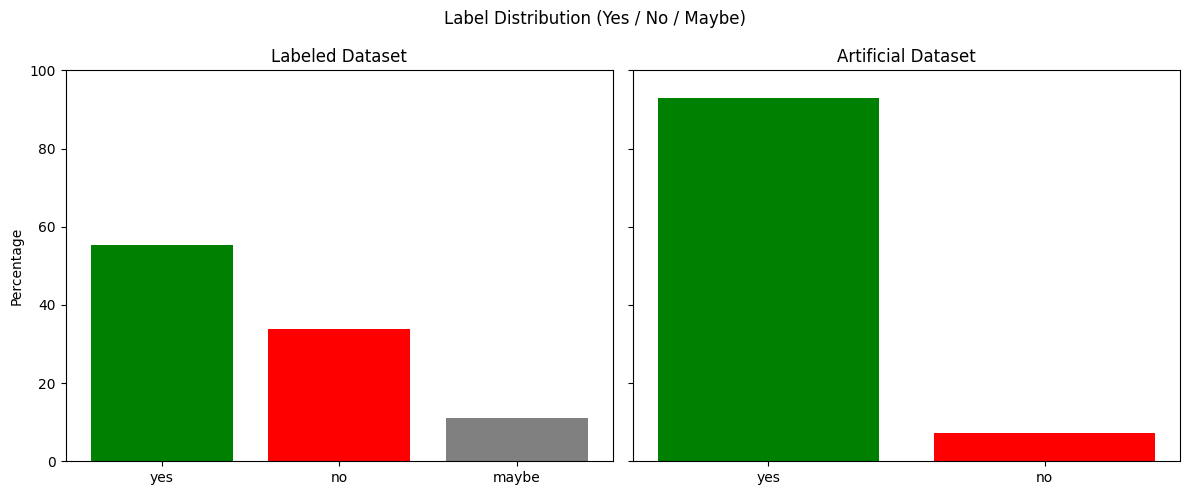

In [14]:
# Create subplots with shared y-axis to ensure the same scale across both bar plots.
# This makes it easier to visually compare the distribution of 'yes', 'no', and 'maybe' labels
# between the labeled and artificial datasets.

# Count label frequencies
labeled_counts = df_labeled['final_decision'].value_counts(normalize=True) * 100  
artificial_counts = df_artificial['final_decision'].value_counts(normalize=True) * 100

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Plot labeled dataset
axes[0].bar(labeled_counts.index, labeled_counts.values, color=['green', 'red', 'gray'])
axes[0].set_title("Labeled Dataset")
axes[0].set_ylabel("Percentage")
axes[0].set_ylim(0, 100)

# Plot artificial dataset
axes[1].bar(artificial_counts.index, artificial_counts.values, color=['green', 'red', 'gray'])
axes[1].set_title("Artificial Dataset")
axes[1].set_ylim(0, 100)

plt.suptitle("Label Distribution (Yes / No / Maybe)")
plt.tight_layout()
plt.show()


### Vocabulary Analysis

The aim of this section is to build and analyse a preliminary vocabulary (before preprocessing) for each dataset. <br>
The analysis will be repeated after the lemmization to compare the results. <br>
We start by building a function to compute the vocabulary. 

In [15]:
# Define a function to build a vocabulary counter from a list of texts:
# it lowercases the text, filters out stopwords and non-alphabetic tokens,
# and counts the frequency of each remaining word.

nltk.download('stopwords')
nltk.download('punkt')

# Stopword List
with open("clinical-stopwords-analysis.txt", "r", encoding="utf-8") as f:
    stop_words = set(line.strip().lower() for line in f if line.strip())

def get_vocab(texts):
    vocab_counter = Counter()
    for text in texts:
        if isinstance(text, str):
            words = text.lower().split()
            filtered_words = [w for w in words if w.isalpha() and w not in stop_words]
            vocab_counter.update(filtered_words)
    return vocab_counter

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\213053\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\213053\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Labeled Vocabulary

In [16]:
# Compute the vocabulary (filtered and lowercased, excluding stopwords) for each feature in the Labeled dataset:
# - questions
# - context (joined list of strings)
# - long answers
# Then print the 10 most common words for each, along with the total vocabulary size per feature.

question_vocab_L = get_vocab(df_labeled['question'])
context_vocab_L = get_vocab([" ".join(ctx['contexts']) for ctx in df_labeled['context']])
long_answer_vocab_L = get_vocab(df_labeled['long_answer'])

print("Vocabulary size in questions:", len(question_vocab_L))
print("Top 10 question words:", question_vocab_L.most_common(10))
print(" ")

print("Vocabulary size in context:", len(context_vocab_L))
print("Top 10 context words:", context_vocab_L.most_common(10))
print(" ")

print("Vocabulary size in long_answer:", len(long_answer_vocab_L))
print("Top 10 long_answer words:", long_answer_vocab_L.most_common(10))

Vocabulary size in questions: 2951
Top 10 question words: [('patients', 107), ('predict', 54), ('risk', 53), ('affect', 42), ('cancer', 40), ('care', 38), ('treatment', 36), ('improve', 33), ('influence', 32), ('breast', 29)]
 
Vocabulary size in context: 10365
Top 10 context words: [('patients', 2044), ('study', 736), ('group', 555), ('compared', 423), ('significantly', 394), ('significant', 383), ('mean', 326), ('data', 320), ('treatment', 313), ('risk', 302)]
 
Vocabulary size in long_answer: 5287
Top 10 long_answer words: [('patients', 293), ('risk', 135), ('study', 121), ('results', 120), ('associated', 109), ('treatment', 87), ('significant', 80), ('care', 70), ('data', 70), ('significantly', 67)]


### Unlabeled Vocabulary

In [17]:
# Compute the vocabulary (filtered and lowercased, excluding stopwords) for each feature in the Unlabeled dataset:
# - questions
# - context (joined list of strings)
# - long answers
# Then print the 10 most common words for each, along with the total vocabulary size per feature.

question_vocab_U = get_vocab(df_unlabeled['question'])
context_vocab_U = get_vocab([" ".join(ctx['contexts']) for ctx in df_unlabeled['context']])
long_answer_vocab_U = get_vocab(df_unlabeled['long_answer'])

print("Vocabulary size in questions:", len(question_vocab_U))
print("Top 10 question words:", question_vocab_U.most_common(10))
print(" ")

print("Vocabulary size in context:", len(context_vocab_U))
print("Top 10 context words:", context_vocab_U.most_common(10))
print(" ")

print("Vocabulary size in long_answer:", len(long_answer_vocab_U))
print("Top 10 long_answer words:", long_answer_vocab_U.most_common(10))

Vocabulary size in questions: 25135
Top 10 question words: [('patients', 6019), ('risk', 3126), ('treatment', 2193), ('cancer', 2157), ('predict', 2031), ('affect', 1987), ('associated', 1864), ('health', 1827), ('improve', 1743), ('care', 1679)]
 
Vocabulary size in context: 71652
Top 10 context words: [('patients', 124962), ('study', 41674), ('group', 35371), ('compared', 25634), ('significant', 23029), ('significantly', 21726), ('risk', 19519), ('mean', 19366), ('associated', 19103), ('data', 18552)]
 
Vocabulary size in long_answer: 41573
Top 10 long_answer words: [('patients', 20522), ('risk', 8286), ('study', 7202), ('results', 7165), ('associated', 6965), ('treatment', 5535), ('significant', 4439), ('health', 4336), ('findings', 4276), ('high', 4089)]


### Artificial Vocabulary

In [18]:
# Compute the vocabulary (filtered and lowercased, excluding stopwords) for each feature in the Artificial dataset:
# - questions
# - context (joined list of strings)
# - long answers
# Then print the 10 most common words for each, along with the total vocabulary size per feature.

question_vocab_A = get_vocab(df_artificial['question'])
context_vocab_A = get_vocab([" ".join(ctx['contexts']) for ctx in df_artificial['context']])
long_answer_vocab_A = get_vocab(df_artificial['long_answer'])

print("Vocabulary size in questions:", len(question_vocab_A))
print("Top 10 question words:", question_vocab_A.most_common(10))
print(" ")

print("Vocabulary size in context:", len(context_vocab_A))
print("Top 10 context words:", context_vocab_A.most_common(10))
print(" ")

print("Vocabulary size in long_answer:", len(long_answer_vocab_A))
print("Top 10 long_answer words:", long_answer_vocab_A.most_common(10))

Vocabulary size in questions: 51549
Top 10 question words: [('associated', 29304), ('patients', 20726), ('cell', 12270), ('human', 12033), ('expression', 10917), ('cells', 10531), ('cancer', 9816), ('predict', 8543), ('risk', 8408), ('factor', 7703)]
 
Vocabulary size in context: 134019
Top 10 context words: [('patients', 272161), ('expression', 119844), ('study', 109274), ('significantly', 107742), ('cells', 105349), ('cell', 95718), ('levels', 91193), ('compared', 90459), ('group', 88096), ('increased', 87261)]
 
Vocabulary size in long_answer: 73057
Top 10 long_answer words: [('patients', 43975), ('results', 33230), ('associated', 32046), ('study', 21367), ('risk', 20590), ('expression', 18244), ('increased', 18079), ('data', 17988), ('findings', 17728), ('treatment', 16905)]


### Complete Vocabulary

In [19]:
# Now we compute the total vocabulary across all three datasets for the 'context' field.
# This is done by combining the vocabularies from the labeled, unlabeled, and artificial datasets.

total_vocab_context = (
    context_vocab_L + context_vocab_U + context_vocab_A
)

# Print the 20 most common words in the combined vocabulary in the context feature, along with the total vocabulary size.
print("Total vocabulary size across all datasets in the context feature:", len(total_vocab_context))
print("Top 20 most common words in the entire corpus of contexts:", total_vocab_context.most_common(20))

Total vocabulary size across all datasets in the context feature: 153119
Top 20 most common words in the entire corpus of contexts: [('patients', 399167), ('study', 151684), ('significantly', 129862), ('group', 124022), ('expression', 122463), ('compared', 116516), ('cells', 108365), ('associated', 105714), ('levels', 102699), ('cell', 100220), ('increased', 99397), ('significant', 87683), ('higher', 76351), ('treatment', 74767), ('risk', 71943), ('analysis', 66401), ('control', 63229), ('effect', 61011), ('blood', 60709), ('protein', 60420)]


In [20]:
# Now we compute the total vocabulary across all three datasets for the 'question' field.
# This is done by combining the vocabularies from the labeled, unlabeled, and artificial datasets.

total_vocab_question = (
    question_vocab_L + question_vocab_U + question_vocab_A
)

# Print the 20 most common words in the combined vocabulary of the question feature, along with the total vocabulary size.
print("Total vocabulary size across all datasets in the question feature:", len(total_vocab_question))
print("Top 20 most common words in the entire corpus of questions:", total_vocab_question.most_common(20))

Total vocabulary size across all datasets in the question feature: 57221
Top 20 most common words in the entire corpus of questions: [('associated', 31192), ('patients', 26852), ('cell', 13270), ('human', 12553), ('cancer', 12013), ('risk', 11587), ('expression', 11201), ('cells', 10773), ('predict', 10628), ('factor', 8845), ('improve', 8724), ('disease', 7812), ('treatment', 7611), ('acute', 7538), ('gene', 7436), ('increased', 7065), ('protein', 6831), ('chronic', 6649), ('growth', 6574), ('levels', 6505)]


In [21]:
# Now we compute the total vocabulary across all three datasets for the 'long_answer' field.
# This is done by combining the vocabularies from the labeled, unlabeled, and artificial datasets.

total_vocab_long_answer = (
    long_answer_vocab_L + long_answer_vocab_U + long_answer_vocab_A
)

# Print the 20 most common words in the combined vocabulary in the long_answer feature, along with the total vocabulary size.
print("Total vocabulary size across all datasets in the long_answer feature:", len(total_vocab_long_answer))
print("Top 20 most common words in the entire corpus of long answers:", total_vocab_long_answer.most_common(20))

Total vocabulary size across all datasets in the long_answer feature: 83675
Top 20 most common words in the entire corpus of long answers: [('patients', 64790), ('results', 40515), ('associated', 39120), ('risk', 29011), ('study', 28690), ('treatment', 22527), ('increased', 22177), ('findings', 22064), ('data', 21750), ('expression', 18819), ('role', 18251), ('levels', 15663), ('high', 15270), ('cell', 15262), ('effect', 14883), ('cells', 14822), ('important', 14590), ('potential', 14083), ('cancer', 13540), ('significant', 13454)]


In [22]:
# Now we compute the total vocabulary across all three datasets for all features combined.
# This is done by combining the vocabularies from the labeled, unlabeled, and artificial datasets.

total_vocab = (
    question_vocab_L + context_vocab_L + long_answer_vocab_L +
    question_vocab_U + context_vocab_U + long_answer_vocab_U +
    question_vocab_A + context_vocab_A + long_answer_vocab_A
)

# Print the 20 most common words in the combined vocabulary across all features, along with the total vocabulary size.
print("Total vocabulary size across all datasets:", len(total_vocab))
print("Top 20 most common words in the entire corpus:", total_vocab.most_common(20))

Total vocabulary size across all datasets: 163230
Top 20 most common words in the entire corpus: [('patients', 490809), ('study', 183171), ('associated', 176026), ('expression', 152483), ('significantly', 144070), ('cells', 133960), ('cell', 128752), ('increased', 128639), ('group', 128636), ('compared', 127461), ('levels', 124867), ('risk', 112541), ('treatment', 104905), ('significant', 102088), ('higher', 90998), ('cancer', 85056), ('effect', 79273), ('disease', 75096), ('analysis', 73806), ('data', 73773)]


### Word Clouds

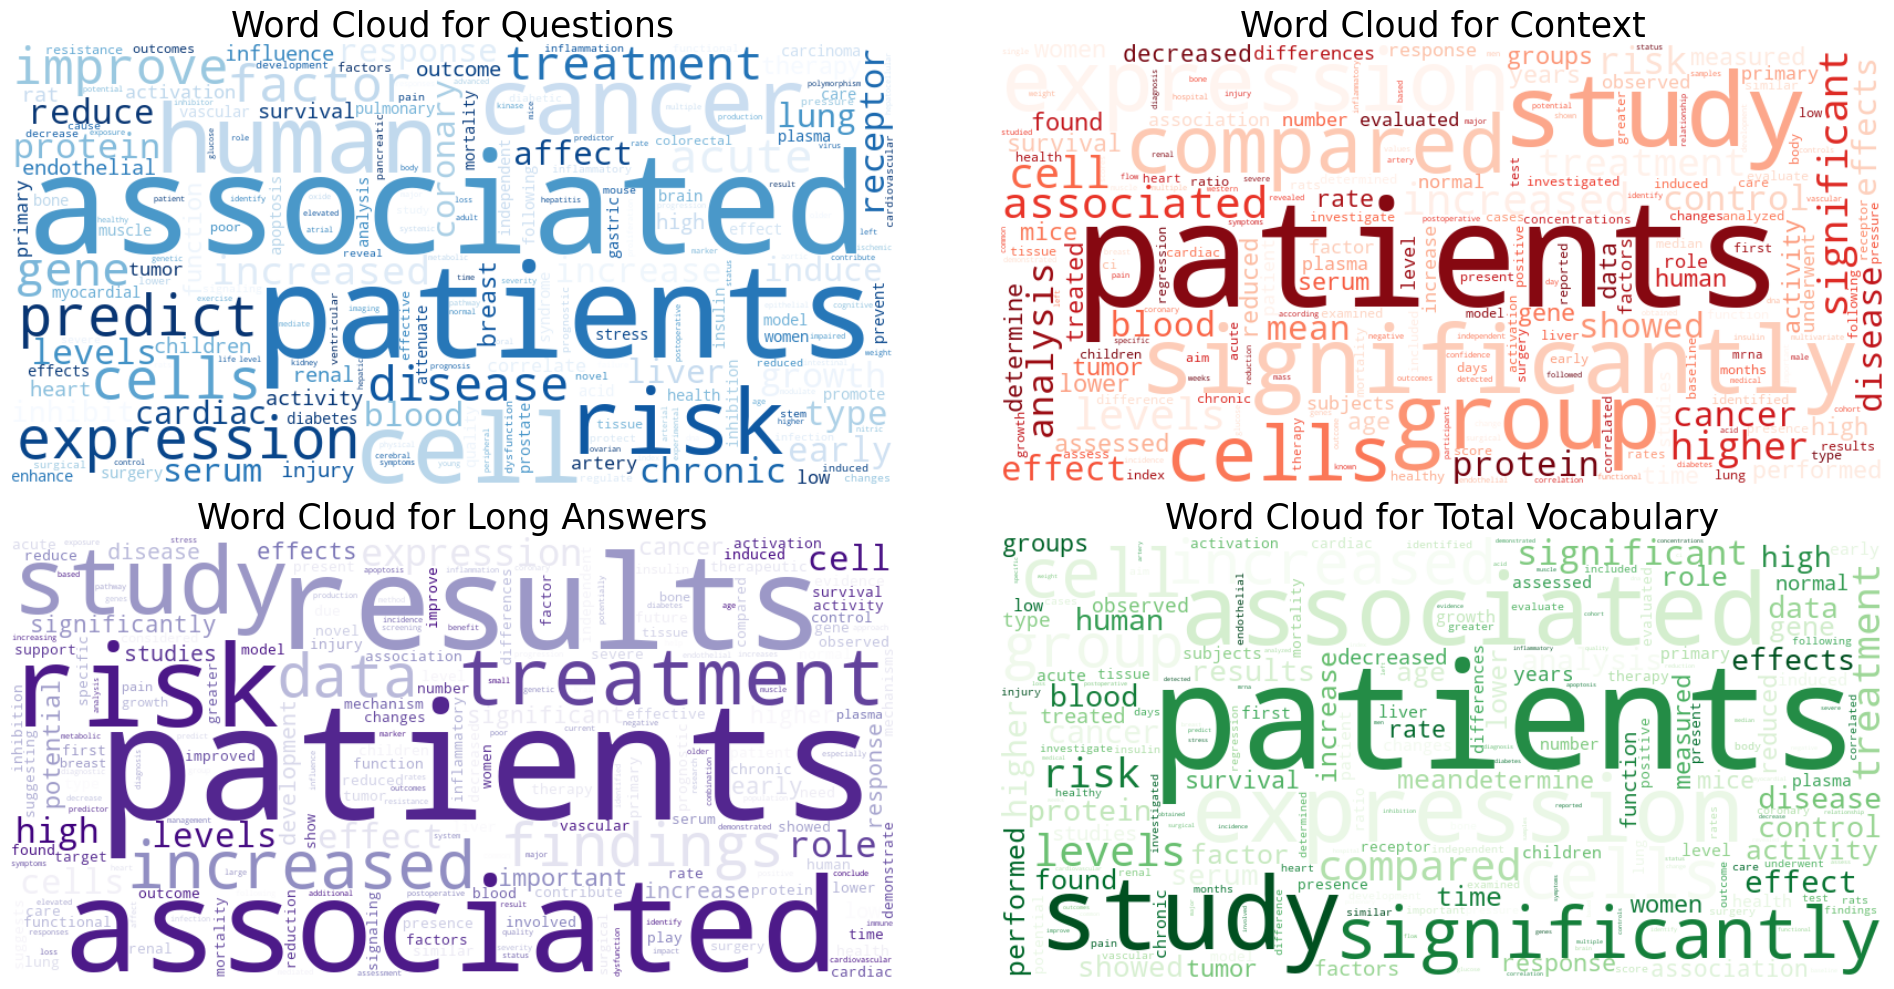

In [23]:
# Now we generate word clouds for the vocabularies of the three features: 'question', 'context', and 'long_answer' and for the total vocabulary across all datasets.
# A word cloud is a visual representation of word frequency, where more frequent words appear larger.
# The function 'generate_wordcloud' takes a vocabulary counter (a dictionary of word frequencies) and a title for the plot.

vocabs = [
    (total_vocab_question, "Questions", "Blues"),
    (total_vocab_context, "Context", "Reds"),
    (total_vocab_long_answer, "Long Answers", "Purples"),
    (total_vocab, "Total Vocabulary", "Greens")  # Aggiungi questo solo se hai total_vocab_total
]

fig, axes = plt.subplots(2, 2, figsize=(20, 10))

for ax, (vocab, title, colormap) in zip(axes.flat, vocabs):
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap=colormap).generate_from_frequencies(vocab)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f"Word Cloud for {title}", fontsize=25)
    ax.axis('off')

plt.tight_layout()
plt.show()


# Preprocessing

We performed the usual steps in preprocessing: 
</n></n>

Before tokenisation <br>
• Lowercase the text <br>
• Remove mark-up (non content information) and punctuations
</n></n>

After tokenisation<br>
• Remove stop words: we used a customized list of stopwords based on [previous works on clinical datasets](https://github.com/salgadev/medical-nlp/blob/master/data/clinical-stopwords.txt)<br>
• Perform lemmatisation: we choose it over stemming as it better preserves meaning, which is crucial for medical question answering<br>
• Perform spelling correction: we avoided this step as the content is taken from official scientific papers, which are typically edited and spell-checked, and auto-correction algorithms could misinterpret rare but valid words, leading to false corrections. 

In [24]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import re
from nltk.tokenize import word_tokenize

nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Lowercase
    text = text.lower()
    
    # Remove non-alphabetic characters
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Removing Stopwords: we changed list to keep valuable indicators such as "no" or "may"
    with open("clinical-stopwords-prepro.txt", "r", encoding="utf-8") as f:
        stop_words = set(line.strip().lower() for line in f if line.strip())

    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatize
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return ' '.join(lemmatized_tokens)


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\213053\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\213053\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\213053\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Now we use the function to preprocess the Unlabeled Dataset:

In [25]:
df_unlabeled['question_lemm'] = df_unlabeled['question'].apply(preprocess_text)
df_unlabeled['context_text'] = df_unlabeled['context'].apply(
    lambda c: " ".join(c['contexts']) if isinstance(c, dict) and 'contexts' in c else ""
)
df_unlabeled['context_lemm'] = df_unlabeled['context_text'].apply(preprocess_text)
df_unlabeled['long_answer_lemm'] = df_unlabeled['long_answer'].apply(preprocess_text)

In [26]:
# Create TF-IDF vectorizers for each feature in the unlabeled dataset in order to perform clustering and similarity analysis.
vectorizer_q = TfidfVectorizer(stop_words='english', max_df=0.5, min_df=5)
X_Q_tfidf_U = vectorizer_q.fit_transform(df_unlabeled['question_lemm'])

vectorizer_c = TfidfVectorizer(stop_words='english', max_df=0.5, min_df=5)
X_C_tfidf_U = vectorizer_c.fit_transform(df_unlabeled['context_lemm'])

vectorizer_la = TfidfVectorizer(stop_words='english', max_df=0.5, min_df=5)
X_LA_tfidf_U = vectorizer_la.fit_transform(df_unlabeled['long_answer_lemm'])

# Ho messo max_df=0.5 e min_df=5 per evitare di avere troppe features perchè sia il kmeans che lda sono poco consistenti per ora

# Clustering

### DA TOGLIERE
The fact that the vectors have length one (almost length of one due to approximations in the representation) means that the dot-product between vectors computes the cosine of the angle between them.
- The cosine of the angle between tf-idf vectors provides a value in the range [0,1], that is often used to measure the similarity between documents.
- Let's compute the similarity between the first two documents in the collection:

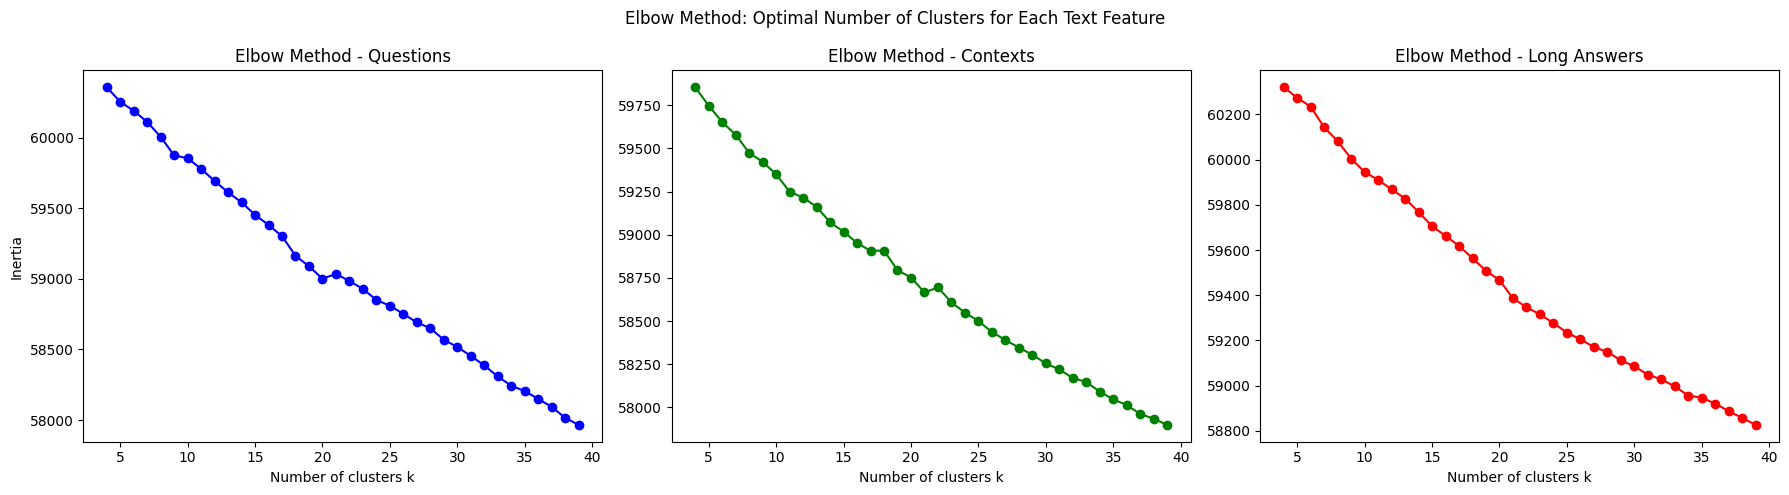

In [27]:

# In this code, we apply the Elbow Method to identify the optimal number of clusters (k) for KMeans clustering. 
# This is done separately for three different text features: questions, contexts, and long answers. 
# The Elbow Method helps us find the value of k where adding more clusters doesn't significantly reduce the inertia 
# (i.e., the sum of squared distances from each point to its assigned cluster center), 
# indicating a good trade-off between model complexity and performance.

# The range of k values to test is set from 2 to 40.
K = range(4, 40)

# Function to compute distortions (inertia) for different values of k
# for a given TF-IDF matrix X. It fits KMeans clustering for each k and appends the inertia to a list.
def compute_distortions(X):
    distortions = []
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        distortions.append(kmeans.inertia_)
    return distortions

# Compute distortions for each feature in the unlabeled dataset (which we are going to use to perform clustering).
distortion_Q = compute_distortions(X_Q_tfidf_U)
distortion_C = compute_distortions(X_C_tfidf_U)
distortion_LA = compute_distortions(X_LA_tfidf_U)


fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(K, distortion_Q, 'bo-')
axes[0].set_title("Elbow Method - Questions")
axes[0].set_xlabel("Number of clusters k")
axes[0].set_ylabel("Inertia")

axes[1].plot(K, distortion_C, 'go-')
axes[1].set_title("Elbow Method - Contexts")
axes[1].set_xlabel("Number of clusters k")

axes[2].plot(K, distortion_LA, 'ro-')
axes[2].set_title("Elbow Method - Long Answers")
axes[2].set_xlabel("Number of clusters k")

plt.suptitle("Elbow Method: Optimal Number of Clusters for Each Text Feature")
plt.tight_layout()
plt.show()


In [28]:
# SISTEMARE IL COMMENTO !!!

# Although an extended analysis using the Elbow method up to k=40 was initially conducted,
# no clear inflection point was identified: the inertia decreased relatively steadily and linearly,
# suggesting that there is no naturally optimal number of clusters in the dataset.

# Additionally, silhouette scores remained consistently low, indicating that the instances
# were not well-separated across the formed clusters. 3D visualizations using dimensionality reduction
# (e.g., TruncatedSVD) further confirmed that data points are heavily agglomerated in the vector space.

# Considering these factors, and in order to avoid computationally expensive tuning (e.g., slow grid search),
# we arbitrarily chose k=5 as the number of clusters for each of the three TF-IDF representations
# (question, context, long_answer), to maintain consistency and enable comparative analysis.

# This is therefore an exploratory choice: clustering is still performed to analyze the data distribution,
# with the understanding that the dataset might not be particularly well-suited for this type of clustering.


k = 5
# Domande
kmeans_Q = KMeans(n_clusters=k, random_state=42)
df_unlabeled['cluster_question_kmeans'] = kmeans_Q.fit_predict(X_Q_tfidf_U)

# Contesto
kmeans_C = KMeans(n_clusters=k, random_state=42)
df_unlabeled['cluster_context_kmeans'] = kmeans_C.fit_predict(X_C_tfidf_U)

# Risposta lunga
kmeans_LA = KMeans(n_clusters=k, random_state=42)
df_unlabeled['cluster_long_answer_kmeans'] = kmeans_LA.fit_predict(X_LA_tfidf_U)

In [29]:

# Stampo il termine significativo di ciascun cluster per le domande
import numpy as np

terms_q = vectorizer_q.get_feature_names_out()
cluster_keywords_Q = {}

for cluster_num in range(k):
    cluster_indices = np.where(df_unlabeled['cluster_question_kmeans'] == cluster_num)[0]
    cluster_tfidf = X_Q_tfidf_U[cluster_indices].mean(axis=0)
    keyword_idx = np.argmax(cluster_tfidf)
    cluster_keywords_Q[cluster_num] = terms_q[keyword_idx]

print(f"The most representative words for each cluster in the question feature are: ", {str(cluster_keywords_Q)})

The most representative words for each cluster in the question feature are:  {"{0: 'difference', 1: 'patient', 2: 'risk', 3: 'cancer', 4: 'treatment'}"}


In [30]:
terms_c = vectorizer_c.get_feature_names_out()
cluster_keywords_C = {}

for cluster_num in range(k):
    cluster_indices = np.where(df_unlabeled['cluster_context_kmeans'] == cluster_num)[0]
    cluster_tfidf = X_C_tfidf_U[cluster_indices].mean(axis=0)
    keyword_idx = np.argmax(cluster_tfidf)
    cluster_keywords_C[cluster_num] = terms_c[keyword_idx]

print(f"The most representative words for each cluster in the context feature are: ", {str(cluster_keywords_C)})

The most representative words for each cluster in the context feature are:  {"{0: 'woman', 1: 'cancer', 2: 'health', 3: 'case', 4: 'group'}"}


In [31]:
terms_la = vectorizer_la.get_feature_names_out()
cluster_keywords_LA = {}

for cluster_num in range(k):
    cluster_indices = np.where(df_unlabeled['cluster_long_answer_kmeans'] == cluster_num)[0]
    cluster_tfidf = X_LA_tfidf_U[cluster_indices].mean(axis=0)
    keyword_idx = np.argmax(cluster_tfidf)
    cluster_keywords_LA[cluster_num] = terms_la[keyword_idx]

print(f"The most representative words for each cluster in the long_answers feature are: ", {str(cluster_keywords_LA)})

# sta lemmizzazione non una grande idea dato che alcune parole ora non hanno senso e le performance sono peggiorate TOP (VOLENDO LO POSSIAMO lasciare per dire che è stato fatto ma non ha senso)
# se no si può provare a fare del downsampling ma non so quanto abbia senso (MEMO: i risultati sono qiasi uguali a quelli senza lemmatizzazione)

The most representative words for each cluster in the long_answers feature are:  {"{0: 'child', 1: 'patient', 2: 'health', 3: 'risk', 4: 'study'}"}


In [32]:
from sklearn.metrics import silhouette_score

# AGGIUNGI COMMENTO

print("Intrinsic evaluation for clustering on questions:")
print("Silhouette Score for the Question feature:", silhouette_score(X_Q_tfidf_U, df_unlabeled['cluster_question_kmeans']))
print("Silhouette Score for the Context feature:", silhouette_score(X_C_tfidf_U, df_unlabeled['cluster_context_kmeans']))
print("Silhouette Score for the Long Answer feature:", silhouette_score(X_LA_tfidf_U, df_unlabeled['cluster_long_answer_kmeans']))

Intrinsic evaluation for clustering on questions:
Silhouette Score for the Question feature: 0.00394203834058956
Silhouette Score for the Context feature: 0.0024209950770934493
Silhouette Score for the Long Answer feature: 0.0022330832708258182


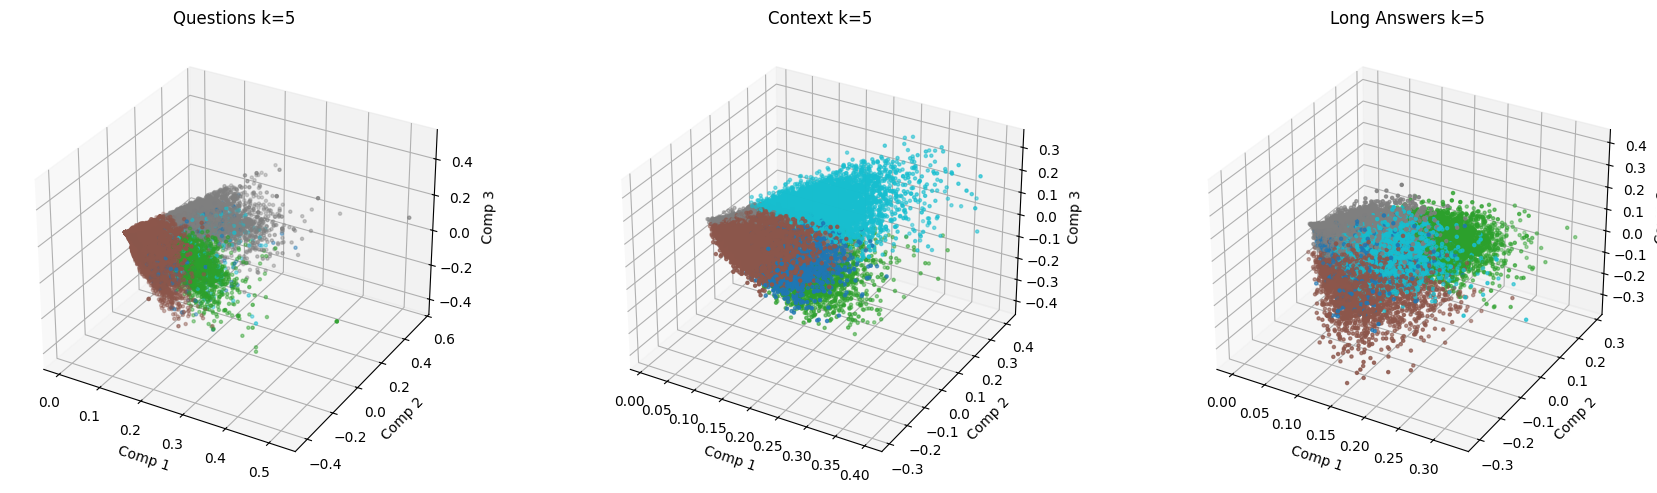

In [33]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def get_svd_3d(X_tfidf):
    svd = TruncatedSVD(n_components=3, random_state=42)
    return svd.fit_transform(X_tfidf)

# Riduzione dimensionale
X_Q_reduced = get_svd_3d(X_Q_tfidf_U)
X_C_reduced = get_svd_3d(X_C_tfidf_U)
X_LA_reduced = get_svd_3d(X_LA_tfidf_U)

# Crea i subplots
fig = plt.figure(figsize=(18, 5))

# Plot domande
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(X_Q_reduced[:, 0], X_Q_reduced[:, 1], X_Q_reduced[:, 2], 
            c=df_unlabeled['cluster_question_kmeans'], cmap='tab10', s=5)
ax1.set_title("Questions k=5")
ax1.set_xlabel("Comp 1")
ax1.set_ylabel("Comp 2")
ax1.set_zlabel("Comp 3")

# Plot contesto
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(X_C_reduced[:, 0], X_C_reduced[:, 1], X_C_reduced[:, 2], 
            c=df_unlabeled['cluster_context_kmeans'], cmap='tab10', s=5)
ax2.set_title("Context k=5")
ax2.set_xlabel("Comp 1")
ax2.set_ylabel("Comp 2")
ax2.set_zlabel("Comp 3")

# Plot risposte lunghe
ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(X_LA_reduced[:, 0], X_LA_reduced[:, 1], X_LA_reduced[:, 2], 
            c=df_unlabeled['cluster_long_answer_kmeans'], cmap='tab10', s=5)
ax3.set_title("Long Answers k=5")
ax3.set_xlabel("Comp 1")
ax3.set_ylabel("Comp 2")
ax3.set_zlabel("Comp 3")

plt.tight_layout()
plt.show()

In [34]:
# per dimostrare che il clustering con il kmeans non sono consistenti, lo rifacciamo con un numero di cluster maggiore (30) e vediamo se i risultati cambiano
# In questo caso, stiamo usando un numero di cluster maggiore (30) per vedere se i risultati cambiano.

k = 30
# Domande
kmeans_Q_30 = KMeans(n_clusters=k, random_state=42)
df_unlabeled['cluster_question_kmeans_30'] = kmeans_Q_30.fit_predict(X_Q_tfidf_U)

# Contesto
kmeans_C_30 = KMeans(n_clusters=k, random_state=42)
df_unlabeled['cluster_context_kmeans_30'] = kmeans_C_30.fit_predict(X_C_tfidf_U)

# Risposta lunga
kmeans_LA_30 = KMeans(n_clusters=k, random_state=42)
df_unlabeled['cluster_long_answer_kmeans_30'] = kmeans_LA_30.fit_predict(X_LA_tfidf_U)

In [37]:
from sklearn.metrics import silhouette_score
# AGGIUNGI COMMENTO (il concept è che kmeans non è adatto per fare questo clustering con tfidf dato che anche se metti 30 cluster 
# la silouette è bassissima e i termini più significativi sono inconsistenti)

print("Intrinsic evaluation for clustering on questions:")
print("Silhouette Score for the Question feature:", silhouette_score(X_Q_tfidf_U, df_unlabeled['cluster_question_kmeans_30']))
print("Silhouette Score for the Context feature:", silhouette_score(X_C_tfidf_U, df_unlabeled['cluster_context_kmeans_30']))
print("Silhouette Score for the Long Answer feature:", silhouette_score(X_LA_tfidf_U, df_unlabeled['cluster_long_answer_kmeans_30']))

Intrinsic evaluation for clustering on questions:
Silhouette Score for the Question feature: 0.011396097033945852
Silhouette Score for the Context feature: 0.006346782616079056
Silhouette Score for the Long Answer feature: 0.005682980494897815


In [35]:
terms_q = vectorizer_q.get_feature_names_out()
cluster_keywords_Q_30 = {}

for cluster_num in range(k):
    cluster_indices = np.where(df_unlabeled['cluster_question_kmeans_30'] == cluster_num)[0]
    cluster_tfidf = X_Q_tfidf_U[cluster_indices].mean(axis=0)
    keyword_idx = np.argmax(cluster_tfidf)
    cluster_keywords_Q_30[cluster_num] = terms_q[keyword_idx]

print(f"The most representative words for each cluster in the long_answers feature are: ", {str(cluster_keywords_Q_30)})

The most representative words for each cluster in the long_answers feature are:  {"{0: 'difference', 1: 'change', 2: 'problem', 3: 'matter', 4: 'carcinoma', 5: 'affect', 6: 'child', 7: 'treatment', 8: 'high', 9: 'therapy', 10: 'patient', 11: 'surgery', 12: 'imaging', 13: 'injury', 14: 'cancer', 15: 'disease', 16: 'quality', 17: 'woman', 18: 'health', 19: 'acute', 20: 'activity', 21: 'possible', 22: 'atrial', 23: 'artery', 24: 'infant', 25: 'prostate', 26: 'influence', 27: 'drug', 28: 'risk', 29: 'liver'}"}


In [36]:
terms_c = vectorizer_c.get_feature_names_out()
cluster_keywords_C_30 = {}

for cluster_num in range(k):
    cluster_indices = np.where(df_unlabeled['cluster_context_kmeans_30'] == cluster_num)[0]
    cluster_tfidf = X_C_tfidf_U[cluster_indices].mean(axis=0)
    keyword_idx = np.argmax(cluster_tfidf)
    cluster_keywords_C_30[cluster_num] = terms_c[keyword_idx]

print(f"The most representative words for each cluster in the long_answers feature are: ", {str(cluster_keywords_C_30)})

The most representative words for each cluster in the long_answers feature are:  {"{0: 'woman', 1: 'cancer', 2: 'stroke', 3: 'case', 4: 'fracture', 5: 'surgery', 6: 'health', 7: 'depression', 8: 'group', 9: 'valve', 10: 'ct', 11: 'ci', 12: 'physician', 13: 'survival', 14: 'pain', 15: 'node', 16: 'biopsy', 17: 'pregnancy', 18: 'bmi', 19: 'sleep', 20: 'injury', 21: 'level', 22: 'knee', 23: 'coronary', 24: 'child', 25: 'infant', 26: 'smoking', 27: 'student', 28: 'hiv', 29: 'cell'}"}


In [37]:
terms_la = vectorizer_la.get_feature_names_out()
cluster_keywords_LA_30 = {}

for cluster_num in range(k):
    cluster_indices = np.where(df_unlabeled['cluster_long_answer_kmeans_30'] == cluster_num)[0]
    cluster_tfidf = X_LA_tfidf_U[cluster_indices].mean(axis=0)
    keyword_idx = np.argmax(cluster_tfidf)
    cluster_keywords_LA_30[cluster_num] = terms_la[keyword_idx]

print(f"The most representative words for each cluster in the long_answers feature are: ", {str(cluster_keywords_LA_30)})

The most representative words for each cluster in the long_answers feature are:  {"{0: 'difference', 1: 'cancer', 2: 'quality', 3: 'woman', 4: 'pain', 5: 'treatment', 6: 'level', 7: 'role', 8: 'infection', 9: 'blood', 10: 'artery', 11: 'study', 12: 'patient', 13: 'significant', 14: 'tumor', 15: 'surgery', 16: 'failure', 17: 'ct', 18: 'child', 19: 'disease', 20: 'risk', 21: 'training', 22: 'diabetes', 23: 'survival', 24: 'care', 25: 'node', 26: 'injury', 27: 'health', 28: 'activity', 29: 'lesion'}"}


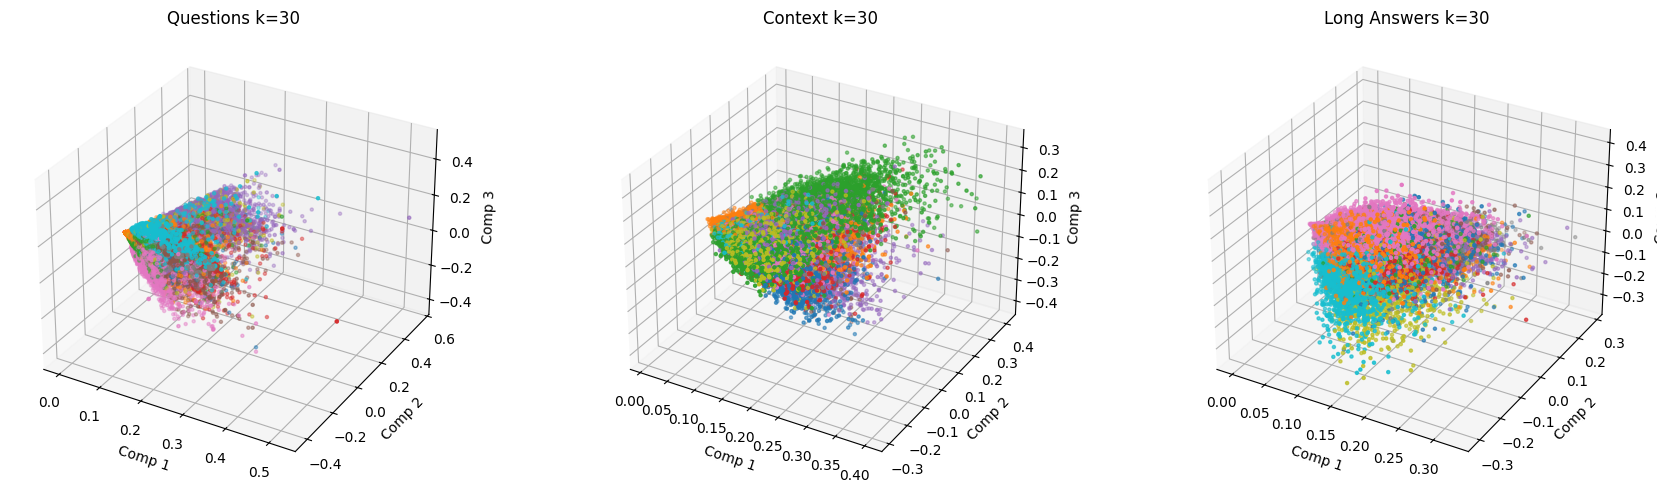

In [38]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def get_svd_3d(X_tfidf):
    svd = TruncatedSVD(n_components=3, random_state=42)
    return svd.fit_transform(X_tfidf)

# Riduzione dimensionale
X_Q_reduced = get_svd_3d(X_Q_tfidf_U)
X_C_reduced = get_svd_3d(X_C_tfidf_U)
X_LA_reduced = get_svd_3d(X_LA_tfidf_U)

# Crea i subplots
fig = plt.figure(figsize=(18, 5))

# Plot domande
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(X_Q_reduced[:, 0], X_Q_reduced[:, 1], X_Q_reduced[:, 2], 
            c=df_unlabeled['cluster_question_kmeans_30'], cmap='tab10', s=5)
ax1.set_title("Questions k=30")
ax1.set_xlabel("Comp 1")
ax1.set_ylabel("Comp 2")
ax1.set_zlabel("Comp 3")

# Plot contesto
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(X_C_reduced[:, 0], X_C_reduced[:, 1], X_C_reduced[:, 2], 
            c=df_unlabeled['cluster_context_kmeans_30'], cmap='tab10', s=5)
ax2.set_title("Context k=30")
ax2.set_xlabel("Comp 1")
ax2.set_ylabel("Comp 2")
ax2.set_zlabel("Comp 3")

# Plot risposte lunghe
ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(X_LA_reduced[:, 0], X_LA_reduced[:, 1], X_LA_reduced[:, 2], 
            c=df_unlabeled['cluster_long_answer_kmeans_30'], cmap='tab10', s=5)
ax3.set_title("Long Answers k=30")
ax3.set_xlabel("Comp 1")
ax3.set_ylabel("Comp 2")
ax3.set_zlabel("Comp 3")

plt.tight_layout()
plt.show()

In [39]:
# KMEANS CON TESTO COMPLETO

df_unlabeled['full_text_lemm'] = (
    df_unlabeled['question_lemm'] + " " +
    df_unlabeled['long_answer_lemm'] + " " +
    df_unlabeled['context_lemm']
)
from sklearn.feature_extraction.text import TfidfTransformer 
vectorizer_fulltext =  TfidfVectorizer(stop_words='english', max_df=0.6, min_df=5)
X_fulltext = vectorizer_fulltext.fit_transform(df_unlabeled['full_text_lemm'])

k = 5
# Domande
kmeans_fulltext = KMeans(n_clusters=k, random_state=42)
df_unlabeled['cluster_fulltext'] = kmeans_fulltext.fit_predict(X_fulltext)


In [43]:
# AGGIUNGERE COMMENTO

print("Intrinsic evaluation for clustering on questions:")
print("Silhouette Score:", silhouette_score(X_fulltext, df_unlabeled['cluster_fulltext']))

Intrinsic evaluation for clustering on questions:
Silhouette Score: 0.0029010815505973323


In [40]:
terms_full_text = vectorizer_fulltext.get_feature_names_out()
cluster_keywords_fulltext = {}

import numpy as np

for cluster_num in range(k):
    cluster_indices = np.where(df_unlabeled['cluster_fulltext'] == cluster_num)[0]
    cluster_tfidf = X_fulltext[cluster_indices].mean(axis=0)
    keyword_idx = np.argmax(cluster_tfidf)
    cluster_keywords_fulltext[cluster_num] = terms_full_text[keyword_idx]

print(f"The most representative words for each cluster in the full text are: ", {str(cluster_keywords_fulltext)})

The most representative words for each cluster in the full text are:  {"{0: 'woman', 1: 'cancer', 2: 'group', 3: 'health', 4: 'group'}"}


Text(0.5, 0, 'Comp 3')

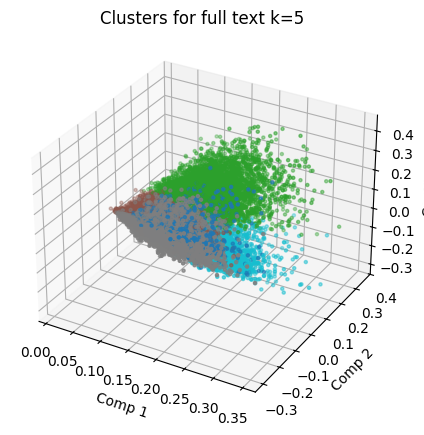

In [41]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def get_svd_3d(X_tfidf):
    svd = TruncatedSVD(n_components=3, random_state=42)
    return svd.fit_transform(X_tfidf)

X_fulltext_reduced = get_svd_3d(X_fulltext)


fig = plt.figure(figsize=(18, 5))

ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_fulltext_reduced[:, 0], X_fulltext_reduced[:, 1], X_fulltext_reduced[:, 2], 
            c=df_unlabeled['cluster_fulltext'], cmap='tab10', s=5)
ax.set_title("Clusters for full text k=5")
ax.set_xlabel("Comp 1")
ax.set_ylabel("Comp 2")
ax.set_zlabel("Comp 3")

## Topic modeling

In [42]:
from sklearn.model_selection import train_test_split

vec_fulltext_train, vec_fulltext_test = train_test_split(df_unlabeled['full_text_lemm'], test_size=0.4)
print('No. training docs:', len(vec_fulltext_train))
print('No. testing docs:', len(vec_fulltext_test))

No. training docs: 36749
No. testing docs: 24500


In [45]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# Vectorization
vectorizer = CountVectorizer(stop_words='english', min_df=5, max_df=.8)
vector_documents_train = vectorizer.fit_transform(vec_fulltext_train)

# LDA
lda = LatentDirichletAllocation(n_components=20, verbose=1, learning_method='online', max_iter=40, random_state=42)  
lda.fit(vector_documents_train)

iteration: 1 of max_iter: 40
iteration: 2 of max_iter: 40
iteration: 3 of max_iter: 40
iteration: 4 of max_iter: 40
iteration: 5 of max_iter: 40
iteration: 6 of max_iter: 40
iteration: 7 of max_iter: 40
iteration: 8 of max_iter: 40
iteration: 9 of max_iter: 40
iteration: 10 of max_iter: 40
iteration: 11 of max_iter: 40
iteration: 12 of max_iter: 40
iteration: 13 of max_iter: 40
iteration: 14 of max_iter: 40
iteration: 15 of max_iter: 40
iteration: 16 of max_iter: 40
iteration: 17 of max_iter: 40
iteration: 18 of max_iter: 40
iteration: 19 of max_iter: 40
iteration: 20 of max_iter: 40
iteration: 21 of max_iter: 40
iteration: 22 of max_iter: 40
iteration: 23 of max_iter: 40
iteration: 24 of max_iter: 40
iteration: 25 of max_iter: 40
iteration: 26 of max_iter: 40
iteration: 27 of max_iter: 40
iteration: 28 of max_iter: 40
iteration: 29 of max_iter: 40
iteration: 30 of max_iter: 40
iteration: 31 of max_iter: 40
iteration: 32 of max_iter: 40
iteration: 33 of max_iter: 40
iteration: 34 of ma

LatentDirichletAllocation(learning_method='online', max_iter=40,
                          n_components=20, random_state=42, verbose=1)

In [46]:
# Performance evaluation on the test set

vector_documents_test = vectorizer.transform(vec_fulltext_test)
perplexity_fulltext = lda.perplexity(vector_documents_test)
print(f"The Perplexity of the lda model is: ", {str(lda.perplexity(vector_documents_test))})

# inserire commento, da capire come interpretare la perplexity

# NB la perplexity è migliorata molto con la lemmizzazione, ma non so se è un buon risultato o meno (da capire se è un buon risultato o meno)
# NB2 la perplexity non migliora significativamente facendo 40 iterazioni invece di 20, quindi non so se ha senso fare 40 iterazioni.

# aumentando da 20 a 30 topic la perplexity rimane invariata, quindi abbasso 20 topic ma alzo molto le iterazioni (60) per vedere se migliora la perplexity
# SPOLIER: rimane quasi invariata

The Perplexity of the lda model is:  {'2250.852042002034'}


In [47]:
vocab = vectorizer.get_feature_names_out()

# Mostra le 10 parole principali per ogni topic
for i in range(len(lda.components_)):
    sorted_terms = lda.components_[i].argsort()[::-1]
    top_words = [vocab[idx] for idx in sorted_terms[:10]]
    concatenated_terms = '[' + ', '.join(top_words) + ']'
    print(f'Topic {i + 1}:\t{concatenated_terms}')

# AGGIUNGERE COMMENTO

Topic 1:	[fracture, bone, prostate, knee, hip, group, mm, mean, study, eye]
Topic 2:	[woman, pregnancy, infant, birth, delivery, week, muscle, maternal, fetal, study]
Topic 3:	[symptom, pain, disorder, score, physical, depression, activity, woman, patient, study]
Topic 4:	[patient, case, diagnosis, lesion, ct, biopsy, positive, node, diagnostic, clinical]
Topic 5:	[correlation, mri, patient, volume, value, test, cognitive, measurement, score, index]
Topic 6:	[cell, expression, tissue, control, cd, gene, disease, human, level, marker]
Topic 7:	[patient, treatment, month, therapy, group, trial, outcome, clinical, intervention, study]
Topic 8:	[infection, test, skin, antibiotic, count, culture, sample, pylorus, study, platelet]
Topic 9:	[patient, surgery, group, complication, postoperative, surgical, procedure, year, rate, outcome]
Topic 10:	[health, child, smoking, social, alcohol, school, adolescent, study, mental, behavior]
Topic 11:	[risk, year, ci, age, factor, associated, study, ana

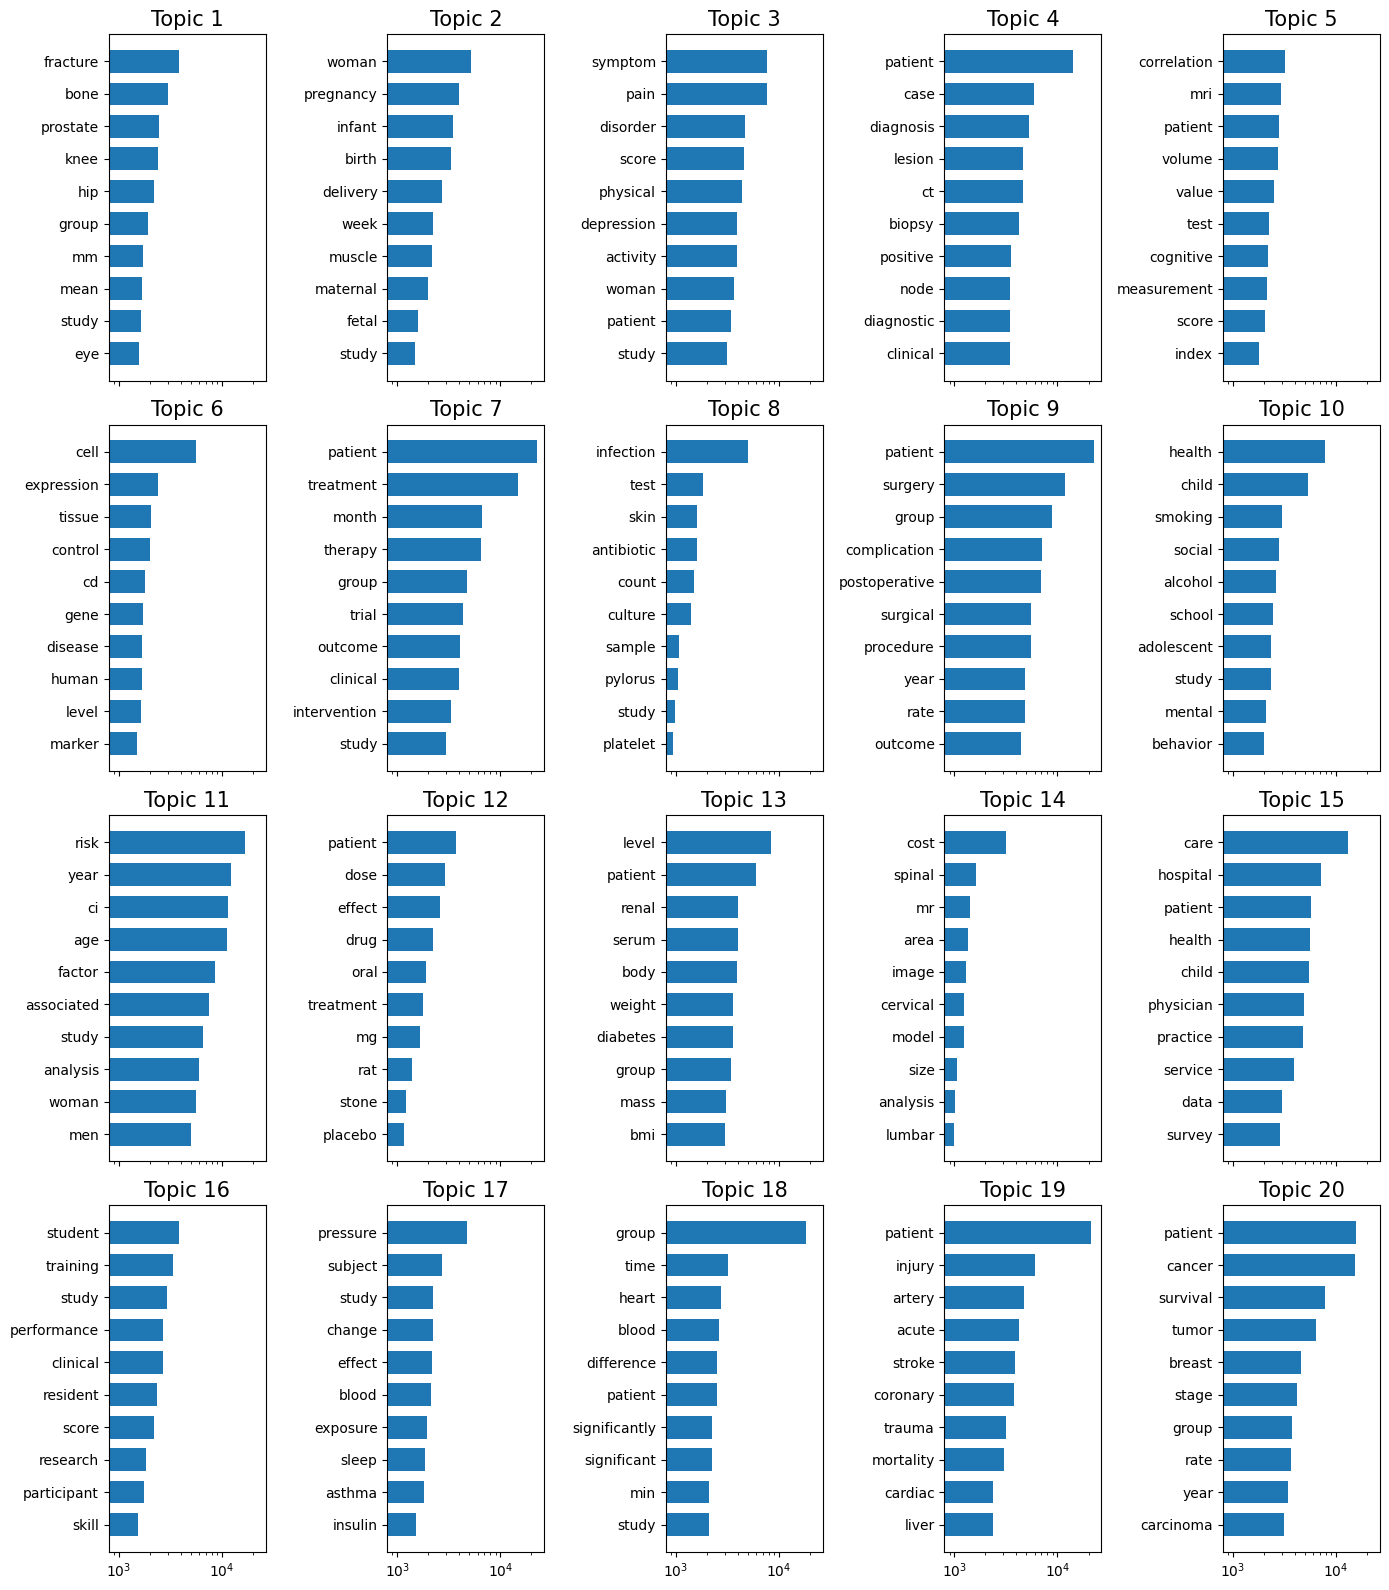

In [48]:
num_words = 10
cols = 5
rows = int(len(lda.components_)/5)

fig, axes = plt.subplots(rows, cols, figsize=(14, 4 * rows), sharex=True)
axes = axes.flatten()
for topic_idx, topic in enumerate(lda.components_):
    top_terms_index = topic.argsort()[:-num_words - 1:-1]
    top_terms = [vocab[i] for i in top_terms_index]
    weights = topic[top_terms_index]
    ax = axes[topic_idx]
    ax.barh(top_terms, weights, height=0.7)
    ax.set_title(f'Topic {topic_idx +1}',fontdict={'fontsize': 15})
    ax.invert_yaxis()
    ax.set_xscale('log')

plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
plt.tight_layout()
plt.show()

In [50]:
# Testiamo il modello LDA sui documenti di test
# Mostra i topic per un documento di test a caso per vedere se il modello ha senso

doc_example = vec_fulltext_test.iloc[1]
print(doc_example)

subfertile woman adjust habit trying conceive subfertile woman onethird overweight obese lifestyle factor known adverse effect fertility tobacco overweight obese woman adjusted habit not reduce body mass index woman fertile age benefit preconception counseling treatment infertility routinely offer intervention lifestyle change woman recruited consecutively first visit fertility clinic midsweden participant completed questionnaire data analyzed logistic regression test chisquare test response rate mean duration infertility year time tobacco daily drank cup coffee day consumed glass alcohol weekly sample woman overweight body mass index bmi kgm obese bmi kgm obese woman exercised changed healthy diet frequently normalweight woman odds ratio confidence interval woman folic acid started trying conceive taking folic acid time taking folic acid associated higher level education


In [51]:
doc_vec_example = vectorizer.transform([doc_example])[0]
topic_vec = lda.transform(doc_vec_example)[0]


In [54]:
sorted_topics = topic_vec.argsort()[::-1]
sorted_prevalence = sorted(topic_vec)[::-1]

In [55]:
for i in range(10):
    if sorted_prevalence[i] < .01: break
    topic = sorted_topics[i]
    sorted_terms = np.flip(lda.components_[topic].argsort())
    print (f'{100 * sorted_prevalence[i]:.1f}% Topic {topic}: {" ".join(vocab[i] for i in sorted_terms[:10])}')

25.6% Topic 12: level patient renal serum body weight diabetes group mass bmi
24.1% Topic 10: risk year ci age factor associated study analysis woman men
14.5% Topic 2: symptom pain disorder score physical depression activity woman patient study
13.3% Topic 9: health child smoking social alcohol school adolescent study mental behavior
9.4% Topic 1: woman pregnancy infant birth delivery week muscle maternal fetal study
4.4% Topic 6: patient treatment month therapy group trial outcome clinical intervention study
4.1% Topic 14: care hospital patient health child physician practice service data survey
1.6% Topic 11: patient dose effect drug oral treatment mg rat stone placebo
1.6% Topic 16: pressure subject study change effect blood exposure sleep asthma insulin


In [ ]:
from sklearn.manifold import TSNE

# Trasformazione TSNE per il test set
tsne_embedding_test = TSNE(n_components=3).fit_transform(lda.transform(vector_documents_test))

# Trasformazione TSNE per il training set
tsne_embedding_train = TSNE(n_components=3).fit_transform(lda.transform(vector_documents_train))

# Controllo delle forme dei dati
print(tsne_embedding_test.shape)
print(tsne_embedding_train.shape)


In [84]:
# Converti i dati in formato (x, y, z) per il test set
[x_test, y_test, z_test] = np.transpose(tsne_embedding_test)

# Converti i dati in formato (x, y, z) per il training set
[x_train, y_train, z_train] = np.transpose(tsne_embedding_train)

In [85]:
# Trasforma i documenti nel formato di distribuzione dei topic
topic_distributions_test = lda.transform(vector_documents_test)
topic_distributions_train = lda.transform(vector_documents_train)

# Ora `topic_distributions` è una matrice di dimensione (num_documenti, num_topic),
# dove ogni riga rappresenta un documento e ogni colonna contiene la probabilità di quel topic nel documento


In [82]:
# Ottieni il topic con la massima probabilità per ogni documento
dominant_topics_train = topic_distributions_train.argmax(axis=1)
dominant_topics_test = topic_distributions_test.argmax(axis=1)

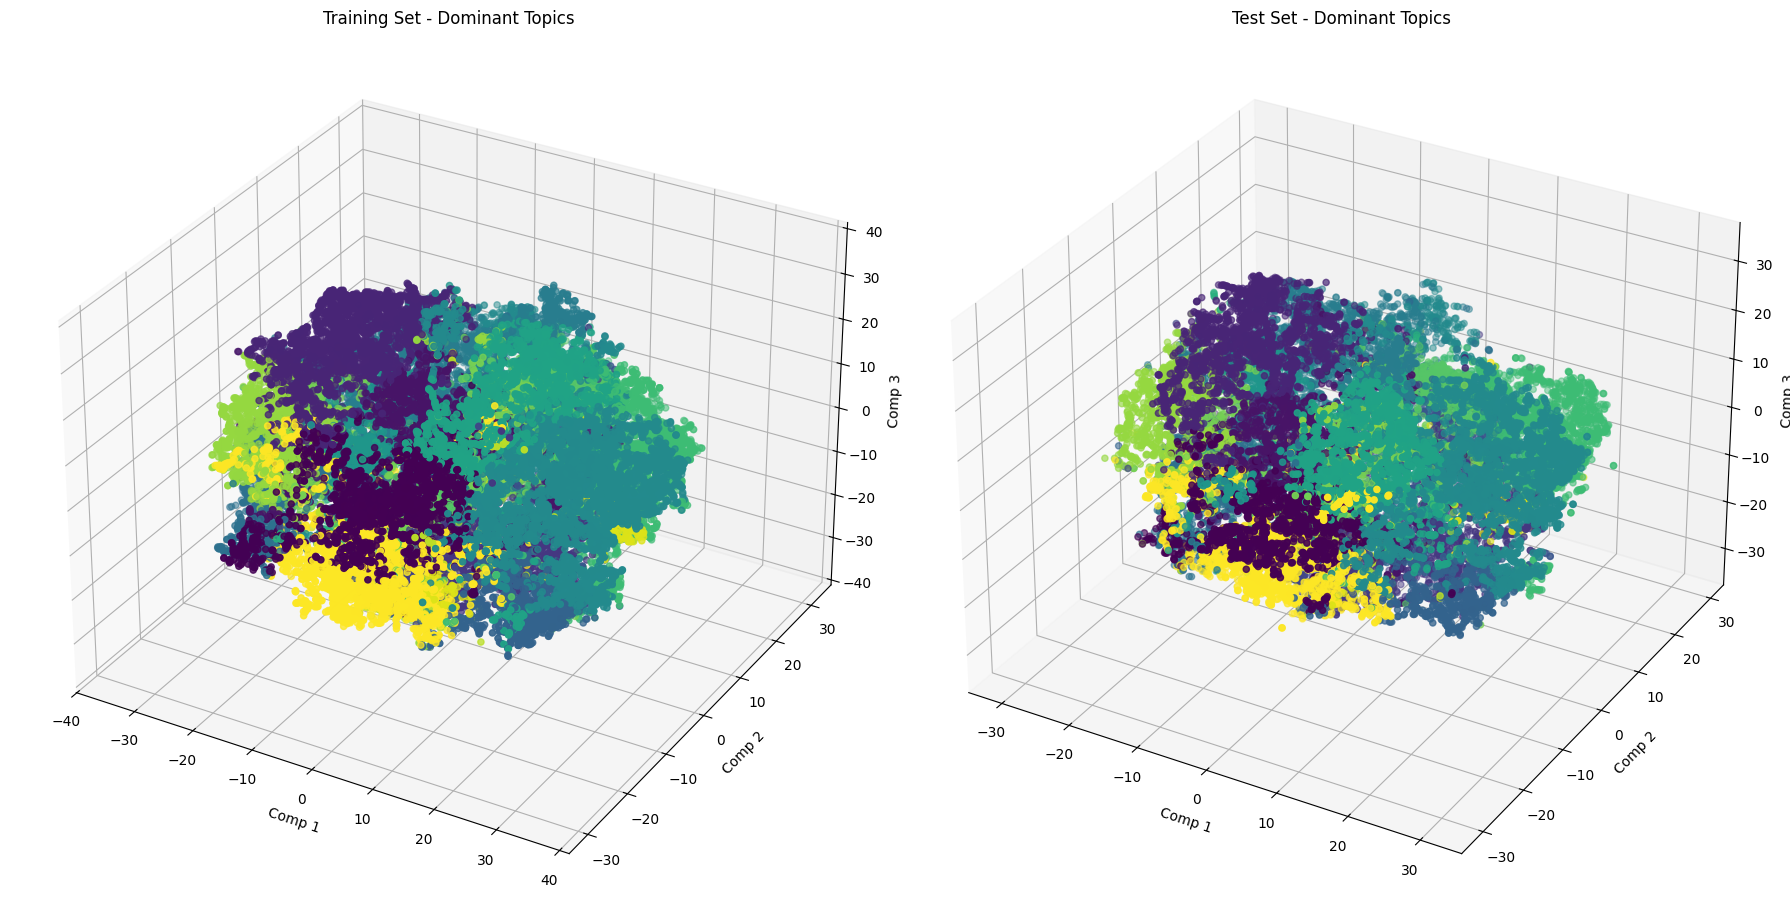

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

# Crea la figura
fig = plt.figure(figsize=(18, 10))

# Plot per il training set
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(x_train, y_train, z_train,
            c=dominant_topics_train)
ax1.set_title("Training Set - Dominant Topics")
ax1.set_xlabel("Comp 1")
ax1.set_ylabel("Comp 2")
ax1.set_zlabel("Comp 3")

# Plot per il test set
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(x_test, y_test, z_test, 
            c=dominant_topics_test)
ax2.set_title("Test Set - Dominant Topics")
ax2.set_xlabel("Comp 1")
ax2.set_ylabel("Comp 2")
ax2.set_zlabel("Comp 3")

# Assicurati che il layout sia ottimizzato per la visualizzazione
plt.tight_layout()

# Prova a forzare la visualizzazione del grafico
plt.show()


## Embedding techniques

In [59]:
print(df_unlabeled.columns)

Index(['pubid', 'question', 'context', 'long_answer', 'question_lemm',
       'context_text', 'context_lemm', 'long_answer_lemm',
       'cluster_question_kmeans', 'cluster_context_kmeans',
       'cluster_long_answer_kmeans', 'cluster_question_kmeans_30',
       'cluster_context_kmeans_30', 'cluster_long_answer_kmeans_30',
       'full_text_lemm', 'cluster_fulltext'],
      dtype='object')


In [ ]:
import pandas as pd
import re
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Scarica risorse necessarie (solo la prima volta)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Preprocessing tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# 1. Preprocessing per documento -> frasi -> token lemmatizzati
def preprocess_sentences_embedding(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    sentences = sent_tokenize(text)
    tokenized_sentences = []
    for sentence in sentences:
        tokens = word_tokenize(sentence)
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
        if tokens:
            tokenized_sentences.append(tokens)
    return tokenized_sentences

# 2. Applichiamo il preprocessing al DataFrame
#'context_text', 'question' e 'long_answer'
all_tokenized_sentences = []
document_token_lists = []

for idx, row in df_unlabeled.iterrows():
    # Uniamo il contenuto delle tre colonne per ogni riga
    combined_text = f"{row['context_text']} {row['question']} {row['long_answer']}"
    
    # Preprocessing sul testo combinato
    tokenized_sentences = preprocess_sentences_embedding(combined_text)
    all_tokenized_sentences.extend(tokenized_sentences)
    
    # Salva tutti i token del documento (flat) per embedding successivo
    flat_tokens = [token for sentence in tokenized_sentences for token in sentence]
    document_token_lists.append(flat_tokens)

df_unlabeled['tokens'] = document_token_lists

# 3. Addestriamo Word2Vec su tutte le frasi tokenizzate
w2v_model = Word2Vec(sentences=all_tokenized_sentences, vector_size=100, window=5, min_count=1, workers=4)

# 4. Creiamo i vettori documento (media dei vettori delle parole)
def document_vector(doc_tokens):
    valid_tokens = [token for token in doc_tokens if token in w2v_model.wv]
    if not valid_tokens:
        return np.zeros(w2v_model.vector_size)
    return np.mean(w2v_model.wv[valid_tokens], axis=0)

df_unlabeled['vector_embedding'] = df_unlabeled['tokens'].apply(document_vector)



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\213053\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\213053\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\213053\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


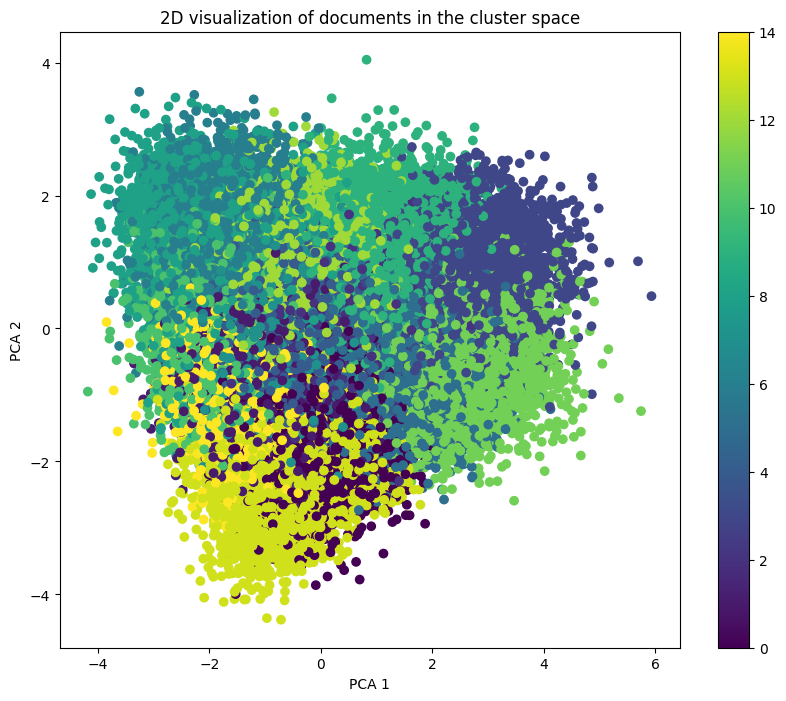

Cluster 0: mgdl, hbac, baseline, ghtnpreeclampsia, fallor
Cluster 1: bernageaus, displacement, sagittal, valgus, volar
Cluster 2: pregnancy, stillbirth, birth, singleton, primigravida
Cluster 3: gps, psychiatrist, pharmacist, client, responsibility
Cluster 4: definite, patient, none, symptomatic, pancreticoduedenectomy
Cluster 5: psychological, psychosocial, cognitive, individual, emotional
Cluster 6: reoperation, redo, operative, reintervention, surgical
Cluster 7: group, initial, thd, prescriptionsyear, carbimazole
Cluster 8: recurrence, adjuvant, pn, unresected, ilc
Cluster 9: gps, gp, physician, appointment, consultation
Cluster 10: fnac, nondiagnostic, suspicious, mri, indeterminate
Cluster 11: employment, social, socioeconomic, psychosocial, spouse
Cluster 12: inhospital, overall, hospitalization, reoperation, mortality
Cluster 13: chemotaxis, enterocyte, cul, rrg, fibrillar
Cluster 14: lvef, cmsec, lvedp, psv, revascularized


In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# RIMETTERLO IN 3D

# 1. Applichiamo K-means sui vettori dei documenti
n_clusters = 15  # Numero di cluster che vuoi generare
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(df_unlabeled['vector_embedding'].apply(np.array).tolist())  # Usa i vettori dei documenti

# 2. Aggiungi i cluster come colonna nel DataFrame
df_unlabeled['cluster'] = kmeans.labels_

# 3. Visualizza i risultati del clustering (riduzione della dimensionalità per visualizzare)
pca = PCA(n_components=2)
reduced_X = pca.fit_transform(np.vstack(df_unlabeled['vector_embedding'].apply(np.array).tolist()))

# Visualizza i dati proiettati su 2D
plt.figure(figsize=(10, 8))
plt.scatter(reduced_X[:, 0], reduced_X[:, 1], c=df_unlabeled['cluster'], cmap='viridis')
plt.colorbar()
plt.title('2D visualization of documents in the cluster space')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

# 4. Analisi dei centri dei cluster (opzionale, per vedere le parole centrali di ogni cluster)
centroids = kmeans.cluster_centers_

# Trova le parole più vicine ai centri di ciascun cluster
for i, centroid in enumerate(centroids):
    closest_words = w2v_model.wv.similar_by_vector(centroid, topn=5)
    print(f"Cluster {i}: {', '.join([word for word, _ in closest_words])}")

In [ ]:
from sklearn.metrics import silhouette_score

# Ottieni la matrice X dei vettori documento
X_vectors = np.vstack(df_unlabeled['vector_embedding'].apply(np.array).tolist())
labels = df_unlabeled['cluster']

# 1. Silhouette Score
sil_score = silhouette_score(X_vectors, labels)
print(f"Silhouette Score: {sil_score:.3f}")

Silhouette Score: 0.077


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\213053\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\213053\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\213053\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Silhouette Score: 0.014


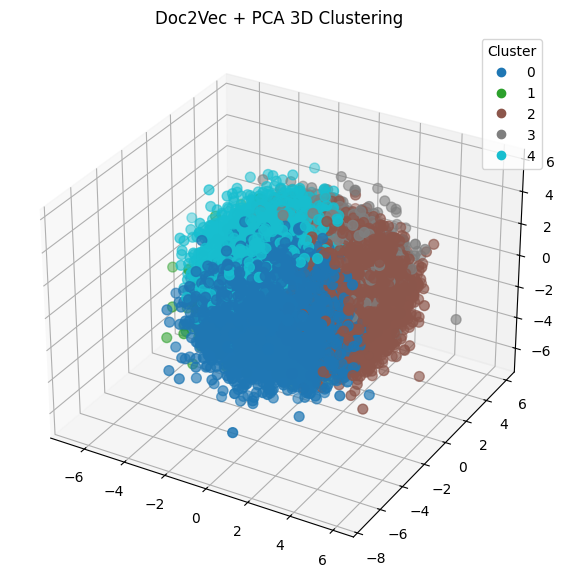

In [73]:
import pandas as pd
import re
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score

# Scarica risorse NLTK se necessario
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Preprocessing tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_sentences(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    sentences = sent_tokenize(text)
    tokenized_sentences = []
    for sentence in sentences:
        tokens = word_tokenize(sentence)
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
        if tokens:
            tokenized_sentences.append(tokens)
    return tokenized_sentences

# 1. Preprocessing unendo 'context_text', 'question' e 'long_answer'
token_lists = []
for idx, row in df_unlabeled.iterrows():
    combined_text = f"{row['context_text']} {row['question']} {row['long_answer']}"
    tokenized_sentences = preprocess_sentences(combined_text)
    flat_tokens = [token for sentence in tokenized_sentences for token in sentence]
    token_lists.append(flat_tokens)

df_unlabeled['tokens'] = token_lists

# 2. Prepara dati per Doc2Vec
tagged_data = [TaggedDocument(words=tokens, tags=[str(i)]) for i, tokens in enumerate(df_unlabeled['tokens'])]

# 3. Addestra Doc2Vec
doc2vec_model = Doc2Vec(tagged_data, vector_size=100, window=5, min_count=1, workers=4, epochs=40)

# 4. Estrai i vettori documento
doc_vectors = np.array([doc2vec_model.dv[str(i)] for i in range(len(tagged_data))])
df_unlabeled['vector_embedding'] = list(doc_vectors)

# 5. Clustering
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df_unlabeled['cluster'] = kmeans.fit_predict(doc_vectors)

# 6. Silhouette Score
sil_score = silhouette_score(doc_vectors, df_unlabeled['cluster'])
print(f"Silhouette Score: {sil_score:.3f}")

# 7. Visualizzazione 3D
pca = PCA(n_components=3)
reduced_vecs = pca.fit_transform(doc_vectors)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(reduced_vecs[:, 0], reduced_vecs[:, 1], reduced_vecs[:, 2],
                     c=df_unlabeled['cluster'], cmap='tab10', s=50)
ax.set_title('Doc2Vec + PCA 3D Clustering')
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()

In [ ]:
# DIVIDERE QUESTO CODICE IN CELLE PIù PICCOLE SE NO RUNNA LENTO

import pandas as pd
import re
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models.fasttext import FastText
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score

# Scarica risorse NLTK se necessario
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Preprocessing tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_sentences(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    sentences = sent_tokenize(text)
    tokenized_sentences = []
    for sentence in sentences:
        tokens = word_tokenize(sentence)
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
        if tokens:
            tokenized_sentences.append(tokens)
    return tokenized_sentences

# 1. Preprocessing unendo 'context_text', 'question' e 'long_answer'
token_lists = []
for idx, row in df_unlabeled.iterrows():
    combined_text = f"{row['context_text']} {row['question']} {row['long_answer']}"
    tokenized_sentences = preprocess_sentences(combined_text)
    flat_tokens = [token for sentence in tokenized_sentences for token in sentence]
    token_lists.append(flat_tokens)

df_unlabeled['tokens'] = token_lists

# 2. Addestra FastText
# Poiché FastText è basato su frasi, dobbiamo unire tutte le frasi in un'unica lista di token
sentences_for_fasttext = df_unlabeled['tokens'].tolist()

fasttext_model = FastText(sentences=sentences_for_fasttext, vector_size=100, window=5, min_count=1, workers=4, epochs=40)

# 3. Estrai i vettori documento
# Calcoliamo i vettori medi di ciascun documento
doc_vectors = np.array([np.mean([fasttext_model.wv[token] for token in tokens if token in fasttext_model.wv], axis=0) 
                       for tokens in df_unlabeled['tokens']])
df_unlabeled['vector_embedding'] = list(doc_vectors)

# 4. Clustering
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df_unlabeled['cluster'] = kmeans.fit_predict(doc_vectors)

# 5. Silhouette Score
sil_score = silhouette_score(doc_vectors, df_unlabeled['cluster'])
print(f"Silhouette Score: {sil_score:.3f}")

# 6. Visualizzazione 3D
pca = PCA(n_components=3)
reduced_vecs = pca.fit_transform(doc_vectors)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(reduced_vecs[:, 0], reduced_vecs[:, 1], reduced_vecs[:, 2],
                     c=df_unlabeled['cluster'], cmap='tab10', s=50)
ax.set_title('FastText + PCA 3D Clustering')
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()

In [ ]:
# IN GENERALE:
# abbiamo fatto il wordembedding con fasttext e doc2vec e word2vec e poi abbiamo fatto il clustering con kmeans per vedere se i risultati miglioravano 
# la silouette è migliorata rieptto alla tfidf ma è comunque vicina allo zero, poi useremo gli embedding anche nalla classificazione
# e vediamo se i risultati migliorano

# NB non so se ha senso rifare la cosa dell'elbow method anche per i vettori con embedding per vedere il numero di cluster ottimale,
# per vedere se in generale overall la coesione interna migliora nonostante la silouhette

# Inoltre per adesso il numero di cluster è 5 (15 in word2vec) quindi bisognerebbe fare qualcosa tipo l'elbow per giustificare il numero di cluster e vedere quello ottimale

# FARE LA VISUALIZZAZIONE DEGLI EMBEDDING CHE QUELLA NON L'ABBIAMO FATTA

# SISTEMARE ANCHE LE COLONNE DEGLI EMBEDDING CHE SI CHIAMANO TUTTE VECTOR_EMBEDDING QUINDI OGNI VOLTA SI SOVRASCRIVE
# Dividere i codici in celle un po' più piccole perchè è lentooo

## Classification task
### Why we applied PCA and visualized the TF-IDF vectors

To better understand whether the automatically generated (artificial) dataset is suitable for training a classifier to be evaluated on the manually labeled dataset, we applied Principal Component Analysis (PCA) to reduce the high-dimensional TF-IDF vectors into two dimensions. We then plotted the projections for both the *questions* and the *long answers*.

This visual inspection allows us to assess:
- How well the artificial and labeled data overlap in the feature space.
- Whether the classifier trained on artificial data could potentially generalize to labeled data.
- Whether the *question*, the *long answer*, or their combination contains more discriminative information.
  
The artificial dataset was generated using a heuristic approach, where "yes" and "no" labels were automatically assigned based on the presence or absence of negation in the question. This means that the labels in the artificial data are **noisy** and might not perfectly represent the true ground truth, as they were not manually assigned by experts but inferred from the structure of the questions. 

Despite this, the artificial data is a valuable resource for **pre-training** the model, as it provides a large volume of labeled examples. However, we must carefully validate the model on the manually labeled data (ground truth) to assess whether it can handle noisy labels and generalize to real-world scenarios. 

This exploratory step is crucial when using **noisily-labeled data** for training and a small amount of **clean labeled data** for validation. Visualizing the data in lower dimensions helps to understand whether it is feasible to train a robust model and what features (questions, long answers, or both) contribute the most to successful classification.


In [24]:
# Sample 10k examples from each class ("yes" and "no") in the artificial dataset to balance the class distribution
no_sample = df_artificial[df_artificial['final_decision'] == 'no'].sample(n=10000, random_state=42)
yes_sample = df_artificial[df_artificial['final_decision'] == 'yes'].sample(n=10000, random_state=42)

# Combine and shuffle the two samples to form a balanced artificial dataset
df_artificial_sampled = pd.concat([yes_sample, no_sample]).sample(frac=1, random_state=42).reset_index(drop=True)

# Add a 'source' column to each dataset to keep track of origin (Artificial vs. Labeled)
# This can later help in evaluating model robustness across domains or training cross-source models
df_artificial_sampled['source'] = 'Artificial'
df_labeled['source'] = 'Labeled'

# Drop examples in the labeled dataset where the label is "maybe"
# Since "maybe" cannot be predicted by a binary classifier trained on "yes"/"no"
df_labeled_clean = df_labeled[df_labeled['final_decision'].isin(['yes', 'no'])].copy()

# Merge the two datasets (balanced artificial + cleaned labeled) keeping only relevant text fields and source info
df_combined = pd.concat([
    df_artificial_sampled[['question', 'long_answer','final_decision', 'source']],
    df_labeled_clean[['question', 'long_answer','final_decision', 'source']]
])

# TF-IDF vectorization of questions and long answers separately
# These matrices can be used independently or concatenated for downstream classifiers
vectorizer = TfidfVectorizer(max_features=50000)
X_Q_tfidf = vectorizer.fit_transform(df_combined['question'])      # TF-IDF features from questions
X_LA_tfidf = vectorizer.fit_transform(df_combined['long_answer'])  # TF-IDF features from long answers


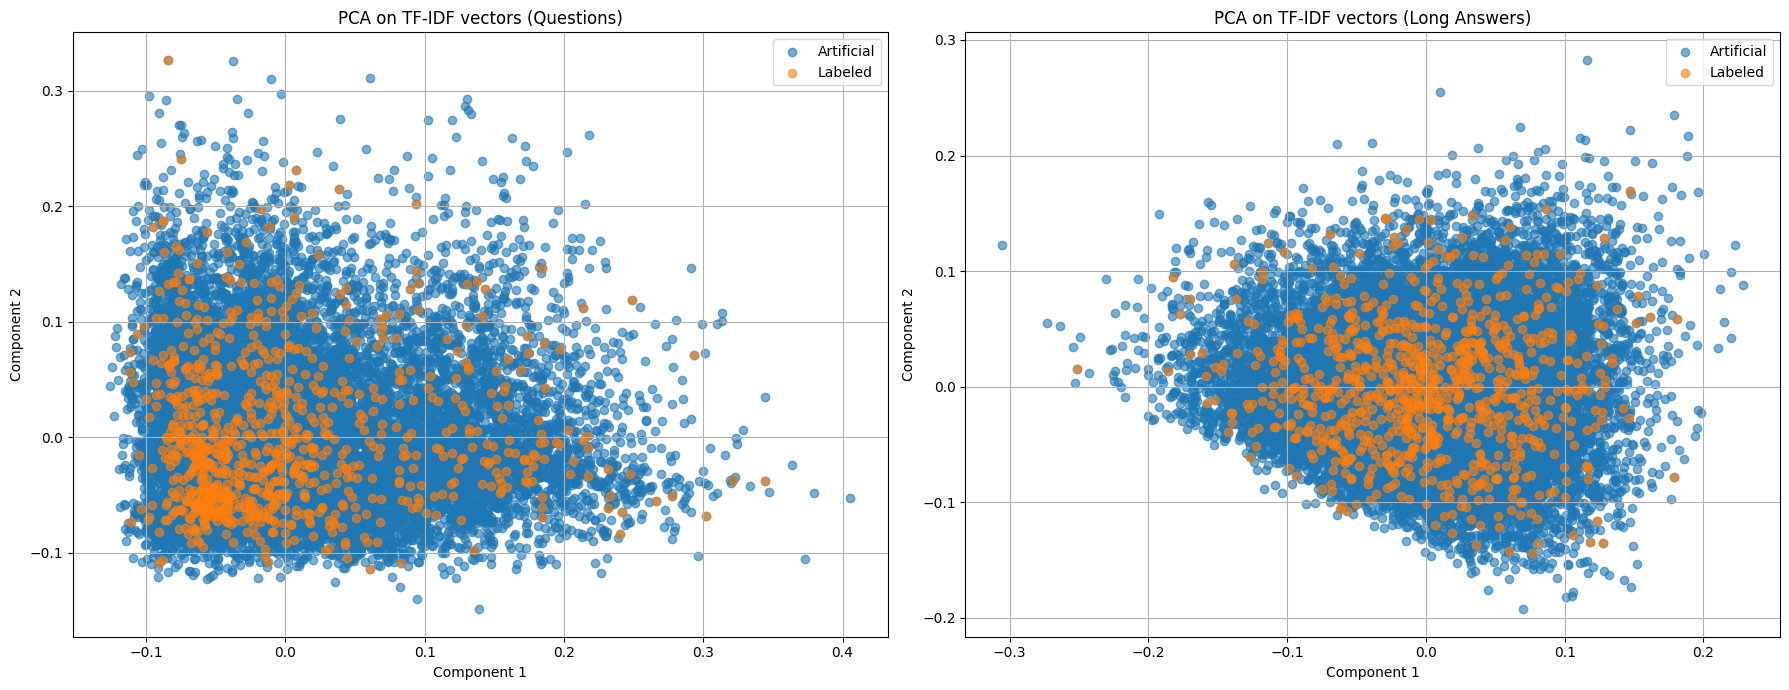

In [ ]:
# Apply PCA to the questions
pca_q = PCA(n_components=2)
X_Q_reduced = pca_q.fit_transform(X_Q_tfidf.toarray())  # Reduce the dimensionality of the question vectors

# Apply PCA to the long answers
pca_la = PCA(n_components=2)
X_LA_reduced = pca_la.fit_transform(X_LA_tfidf.toarray())  # Reduce the dimensionality of the long answer vectors

# Create a figure with 2 side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Plot for questions
for source in df_combined['source'].unique():  # Loop through each unique source (Artificial and Labeled)
    subset = df_combined[df_combined['source'] == source]  # Subset the data based on the source
    axes[0].scatter(
        X_Q_reduced[subset.index, 0],  # First principal component of the questions
        X_Q_reduced[subset.index, 1],  # Second principal component of the questions
        label=source,  # Label the points by source (Artificial or Labeled)
        alpha=0.6  # Set transparency for better visualization
    )
axes[0].set_title("PCA on TF-IDF vectors (Questions)")  
axes[0].set_xlabel("Component 1")  
axes[0].set_ylabel("Component 2")  
axes[0].legend()  
axes[0].grid(True) 

# Plot for long answers
for source in df_combined['source'].unique():  # Loop through each unique source (Artificial and Labeled)
    subset = df_combined[df_combined['source'] == source]  # Subset the data based on the source
    axes[1].scatter(
        X_LA_reduced[subset.index, 0],  # First principal component of the long answers
        X_LA_reduced[subset.index, 1],  # Second principal component of the long answers
        label=source,  
        alpha=0.6  
    )
    
axes[1].set_title("PCA on TF-IDF vectors (Long Answers)")  
axes[1].set_xlabel("Component 1")  
axes[1].set_ylabel("Component 2")  
axes[1].legend()  
axes[1].grid(True)  

plt.tight_layout()
plt.show()

# provare ad aggiungere contesto che era troppo lungo

In [ ]:
# We build separate TF-IDF vectorizers for the 'question' and 'long_answer' fields.
# First, we fit each vectorizer on the artificial (larger and noisier) dataset to extract the vocabulary and term weights.
# Then, we use the same fitted vectorizers to transform the labeled clean dataset, ensuring that both datasets are projected
# into the same feature space (i.e., with the same number and order of features).
# This is crucial because we want to train classification models on the artificial dataset (X_Q_tfidf_A and X_LA_tfidf_A),
# and then evaluate them on the clean labeled dataset (X_Q_tfidf_L and X_LA_tfidf_L), which serves as a reliable benchmark.
# Finally, we extract the corresponding labels for supervised learning (y_A for training, y_L for validation).

# We use TfidfVectorizer to convert the text data into TF-IDF features.

# Questions
vectorizer_q = TfidfVectorizer(max_features=50000)
X_Q_tfidf_A = vectorizer_q.fit_transform(df_artificial_sampled['question'])
X_Q_tfidf_L = vectorizer_q.transform(df_labeled_clean['question'])

# Long Answers
vectorizer_la = TfidfVectorizer(max_features=50000)
X_LA_tfidf_A = vectorizer_la.fit_transform(df_artificial_sampled['long_answer'])
X_LA_tfidf_L = vectorizer_la.transform(df_labeled_clean['long_answer'])

# Label
y_A = df_artificial_sampled['final_decision']
y_L = df_labeled_clean['final_decision']


In [ ]:
# The classification results were obtained by providing the classifier with only the questions (no long answers).
# Results on the labeled dataset are as follows:
# - SVM - Accuracy: 0.5326
# - Logistic Regression - Accuracy: 0.5281
# - Random Forest - Accuracy: 0.4472
# 
# The best model is SVM with an accuracy of 53.26%. However, the overall accuracy is relatively low,
# which could be due to the limited information provided by only using the questions without considering the long answers.
# This suggests that incorporating more contextual information (e.g., long answers) might improve the model's performance.

# We will train and evaluate several classifiers on the artificial dataset (X_Q_tfidf_A, y_A) and validate them on the labeled dataset (X_Q_tfidf_L, y_L).
# The classifiers include SVM, Logistic Regression, Random Forest.
models = {
    'SVM': SVC(C=1, kernel='linear', random_state=42, probability=True),
    'Logistic Regression': LogisticRegression(C=1, random_state=42, solver='lbfgs', max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10, min_samples_split=5),
}

best_model = None
best_model_name = ""
best_accuracy = 0

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_Q_tfidf_A, y_A)  
    y_pred = model.predict(X_Q_tfidf_L)  
    acc = accuracy_score(y_L, y_pred)
    print(f"{name} - Accuracy on Labeled dataset: {acc:.4f}")
    
    if acc > best_accuracy:
        best_accuracy = acc
        best_model = model
        best_model_name = name

# Print the best model and its accuracy
print(f"\nBest model on Labeled dataset: {best_model_name} with accuracy: {best_accuracy:.4f}")
print("\nClassification report:")
print(classification_report(y_L, best_model.predict(X_Q_tfidf_L)))


SVM - Accuracy on Labeled dataset: 0.5326
Logistic Regression - Accuracy on Labeled dataset: 0.5281
Random Forest - Accuracy on Labeled dataset: 0.4472

Best model on Labeled dataset: SVM with accuracy: 0.5326

Classification report:
              precision    recall  f1-score   support

          no       0.43      0.74      0.55       338
         yes       0.72      0.40      0.52       552

    accuracy                           0.53       890
   macro avg       0.58      0.57      0.53       890
weighted avg       0.61      0.53      0.53       890



In [ ]:
# In this cell, we train and evaluate multiple classifiers to identify the best-performing model
# when using only the 'long_answer' text as input features instead of the 'question' field.
# We vectorize the 'long_answer' using a TF-IDF representation, train on the artificial labeled dataset,
# and evaluate model performance on the clean labeled dataset. This setup allows us to assess
# whether the additional contextual information present in long answers improves classification accuracy.

# Results summary:
# When using the 'long_answer' field as input features (TF-IDF vectorized), all classifiers significantly outperform 
# those trained only on the 'question' field. The best model in this case is Logistic Regression, 
# achieving an accuracy of 77.64% on the labeled dataset.
# The classification report shows a strong performance for both classes, especially for the 'yes' class 
# with precision 0.83 and recall 0.80. These results suggest that long answers contain richer and more informative 
# content, allowing the model to better capture patterns associated with the final decision.

models = {
    'SVM': SVC(C=1, kernel='linear', random_state=42, probability=True),
    'Logistic Regression': LogisticRegression(C=1, random_state=42, solver='lbfgs', max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10, min_samples_split=5),
}

best_model = None
best_model_name = ""
best_accuracy = 0

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_LA_tfidf_A, y_A)  
    y_pred = model.predict(X_LA_tfidf_L)  
    acc = accuracy_score(y_L, y_pred)
    print(f"{name} - Accuracy on Labeled dataset: {acc:.4f}")
    
    if acc > best_accuracy:
        best_accuracy = acc
        best_model = model
        best_model_name = name

# Print the best model and its accuracy
print(f"\nBest model on Labeled dataset: {best_model_name} with accuracy: {best_accuracy:.4f}")
print("\nClassification report:")
print(classification_report(y_L, best_model.predict(X_LA_tfidf_L)))

SVM - Accuracy on Labeled dataset: 0.7753
Logistic Regression - Accuracy on Labeled dataset: 0.7764
Random Forest - Accuracy on Labeled dataset: 0.7506

Best model on Labeled dataset: Logistic Regression with accuracy: 0.7764

Classification report:
              precision    recall  f1-score   support

          no       0.69      0.74      0.72       338
         yes       0.83      0.80      0.82       552

    accuracy                           0.78       890
   macro avg       0.76      0.77      0.77       890
weighted avg       0.78      0.78      0.78       890



In [ ]:
# PER LA CLASSIFICAZIONE (COSE DA FARE)
# 1. fare la classificazione con gli embedding (CON LA STESSA PIPELINE PERò)
# 2. Fare vari classificatori e prendere i miglliori, classificare unlabeled e vedere quanto i modelli sono daccordo tra loro (di modo da rendere più robusta la classificazione)
# 3. in generale usare anche altri modelli di classificazione più complessi (XGBoost, LightGBM, ecc.) e vedere se migliorano i risultati

In [ ]:
# COSE DA FARE 
# 1. settare meglio tutta la parte del clustering (eventualmente provare altri algoritmi), sistemare i commenti, mettere delle considerazioni sui risultati
#   - NB Sperimentare anche di più per gli embedding
# 2. la classificazione (vedi sopra)
# 3. indexing documents per fare la keyword search